In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve, plot_roc_curve,precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import svm



plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this chapter we will **only talk about classification**. Classifiers associate a transformed set of features to one of two class (a discrete variable): 0 or 1. Even when doing multiclass classification you always go back (thanks to some algo) to a problem of two classes: 0 or 1.


In this notebook we are going to focus on distance based classification method (opposed to decision tree for example). The goal is to give you some insight on 4 different levels:
- **Best practice** 
- **Intuition on the concepts behind those methods**
- **How to implement them with Scikitlearn**
- **Intuition on the different parameters that your model need but are not trainable (hyperparameters)**

# Distance based classification method
## Table Of Content:

* [**Feature selection**](#feature)

* [**Which Classifier**](#which_cl)

* [**K-nearest neighbors : introduction to basic routine in ML**](#neighbors)
    * [Toy dataset: concepts and hyperparameters](#KN-concepts)
    * [Cancer dataset/introduction to relevant metrics](#K-cancer)
    * [Iris dataset: a multiclass dataset ](#MC-KN)
    
    
* [**Logistic regression and the ooportunity to use AUC ROC**](#Logistic-regression)
    * [Concepts: what is linear and introduction to regularization](#Logistic-regression)
    * [Toy dataset: introdution to the AUC ROC](#AUC-ROC)
    * [Imbalanced classes](#Unbalanced)
    * [Cancer dataset: playing around with the Logistic regression hyperparameters](#LR-hyper)
    * [Iris dataset: multiple classes](#LR-IRIS)
    
    
* [**Support Vector Machine**](#SVM)
    * [Concepts](#SVM)
    * [Toy dataset with linear kernel](#SVM-linear)
    * [Toy dataset with nonlinear kernel](#SVM-nonlinear)
    * [Cancer dataset: playing with the hyperparameters](#SVM-hyperparameters)
    

* [**Appendix**](#appendix)
    * [Logistic regression multiclass examples](#LR-MC)

* [**Exo**](#exo)

In [62]:
# Multiclassification data set
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()

df_iris = pd.concat([pd.DataFrame(iris['data'],columns=iris['feature_names']),\
                       pd.DataFrame(iris['target'],columns=['species'])],axis=1)


(X_iris, y_iris) = load_iris(return_X_y = True)

#Classification data set
#check sklearn.datasets.load_breast_cancer for more documentation and the original reference
#Wolberg et al, Cencer Letters 1994, https://doi.org/10.1016/0304-3835(94)90099-X for a precise 
#description of the features
#See notebook 1, Appendix for a PCA plot of the data

from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

print('Nr benign cells = {0}, Nr malignent cells = {1}'.format(sum(y_cancer==1),sum(y_cancer==0)))

df_cancer.head()


Nr benign cells = 357, Nr malignent cells = 212


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


# Feature selection  <a class="anchor" id="feature"></a>

Feature selection reduces the dimensionality of the problem, which can improve the performance of ML algorithms. Feature selection can be done prior to the ML part or can be fully intergrated into the ML algorithm (e.g. logistic regression, see below) or pipeline. sklearn offers various feature selection routines. Here we look at SelectFdr: For every (non-negative) feature it performs a ANOVA F-test to evaluate the association between feature values and classes. Then it performs multiple testing on the F-test p-values. Many other selection criteria can be found in [sklearn.feature_selection](https://scikit-learn.org/stable/modules/feature_selection.html).

In [42]:
from sklearn.feature_selection import SelectFdr, f_classif

feature_selector = SelectFdr(f_classif, alpha=0.01)
X_cancer_sel = feature_selector.fit_transform(X_cancer, y_cancer)

M = X_cancer.shape[1]
indices = feature_selector.get_support(indices=True)
selected_features = df_cancer.columns[indices]
deleted_features = df_cancer.columns[[i for i in np.arange(M) if i not in indices]]

print(X_cancer.shape)
print(X_cancer_sel.shape)
print("Selected features: "+str(selected_features))
print("Deleted features: "+str(deleted_features))

(569, 30)
(569, 25)
Selected features: Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'radius error',
       'perimeter error', 'area error', 'compactness error', 'concavity error',
       'concave points error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'],
      dtype='object')
Deleted features: Index(['mean fractal dimension', 'texture error', 'smoothness error',
       'symmetry error', 'fractal dimension error'],
      dtype='object')


# Which Classifier Should We Choose? <a class="anchor" id="which_cl"></a>

* There is a mthematical theorem that says that there is no universally best classifier. It really depends on the data!
* One needs to test several classifiers for each dataset and compare the results.
* Best is to have a few favorite classifiers (e.g. kNN, LR, SVM), which you know well, and which are somehow complementary (local density based, linear, or inbetween)

# K-nearest neighbors classifier <a class="anchor" id="neighbors"></a>

For a classifier, k-nearest neighbors works as follow. **First the algorithm simply saves the labels that it is given during the training phase**. Then during the testing phase it takes a testing point and checks its 'n_neighbors' nearest neighbors in the training points. **If 'n_neighbors' nearest neighbors are mostly (in majority) from one label then the tested point will be assigned this label**. The way the 'n_neighbors' **nearest neighbors vote** can be either uniform (every point as the same importance in the vote) or distance (a point distant to the tested point by a distance d will have a weight of 1/d in the vote).

#### Toy data set <a class="anchor" id="KN-concepts"></a>

In [43]:
#Let's make some toy dataset. Here using the sklearn function making blobs for you!!!

from sklearn.datasets import make_blobs
X_3, y_3 = make_blobs(n_samples=120, centers=3,cluster_std=[[1,3],[1,3],[1,3]], random_state=6)# 120 points, 
#3 blobs/clusters with some spread= 1 in x-direction and 3 in y-direction
#Random_state is here just to be sure that every time you will get the same blobs. If you change the random_state or do not
#specify it then you will get a new plot every time you call the function (random seed)

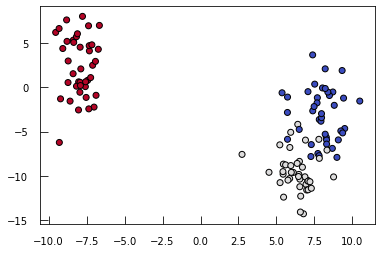

In [44]:
plt.scatter(X_3[:,0],X_3[:,1],c=y_3,cmap=plt.cm.coolwarm,edgecolors='k')
plt.show()

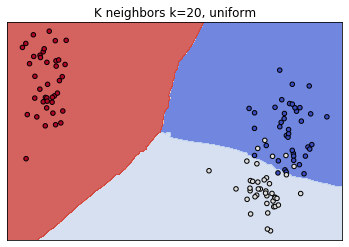

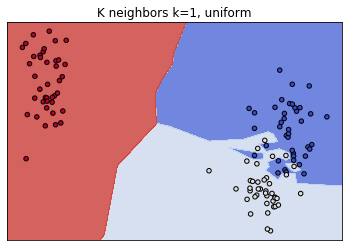

In [45]:
from utils import countour_knn
countour_knn(20,X_3,y_3,'uniform')
countour_knn(1,X_3,y_3,'uniform')

In the above we varied the number of voters (neighbors) to decide weither a point is from one class or another. You can see how the **boundaries are way more wiggly and attentive to missclassification when the number of neighbors is low**. But you can also imagine that if **new data is added those kind of too specific boundaries are going to missclaissify the new points. This is a first example of this bias variance trade off: 1-NN has a large variance, 20-NN may have some bias**.

In the simple case where all blobs have equal covariance matrix, we can show (discriminant analysis) that the optimal class boundaries are linear. A high value of $k$=20 seems to best correspond to a linear boundary in this example.

Another parameter determines whether we use the distance as weight for the voring. Of course for only 1 neighbor this is the same graph as before. But for 20 neighbors you can see that the line becomes a bit more wiggly - a sign of larger variance.

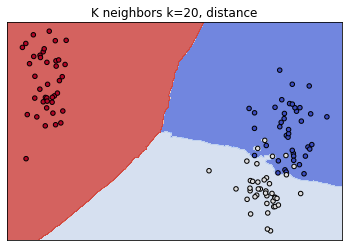

In [6]:
countour_knn(20,X_3,y_3,'distance')

#### Cancer dataset <a class="anchor" id="K-cancer"></a>

One straight forward metric to evaluate the performance of a classifier is the accuracy. Accuracy is most relevant on the test set, even though it can give you some good insight about your model when accuracy is compared between test and training set (overfitting, see below). Be aware that accuracy works best for balanced classes (same number of cases). For very unbalanced classes the accurarcy can be high just by chance (see below).


Accuracy is defined as follow : $\frac{TP+TN}{P+N}$

TP : True Positive

TN : True Negative

FP : False Positive

FN : False Negative

P : Positive

N : Negative


Of course $P=TP+FN$ and $N=TN+FP$


In [46]:
from sklearn.metrics import accuracy_score

Kneighbors = KNeighborsClassifier(n_neighbors = 1, weights='uniform')
Kneighbors.fit(X_cancer, y_cancer)

y_pred = Kneighbors.predict(X_cancer)

print('Acc = {0:.3f} on cancer data!?'.format(accuracy_score(y_cancer, y_pred)))

Acc = 1.000 on cancer data!?


**We have to divide our data set into a train and a test set**. The **test set should never be touched until the last step which is the model evaluation**. By doing so we can be confident that our measure of generalization efficiency of our model is as correct as it can be. This is why no information coming from the test set should leak into the train set. If so we are biasing our understanding of the generalizability of our model. I would like to give you some examples of that but I will need to use many tools that we haven't touched yet. So for now believe me on the necessity to split dataset. Maybe later when you will have all those tools try to persuade yourself.

In [63]:
from sklearn.model_selection import train_test_split

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = \
        train_test_split(X_cancer, y_cancer,random_state=7,stratify=y_cancer) 
#default is 75% training, 25% testing

#train_test_split make sure to split the data so that the two partitions ressemble each other statistically speaking
#For example a bad splitting would be that your training set have 99% of one label and your testing set 99% of the other....

Kneighbors = KNeighborsClassifier(n_neighbors = 1, weights='uniform',n_jobs=-1)
Kneighbors.fit(X_cancer_train, y_cancer_train)

y_pred_test=Kneighbors.predict(X_cancer_test)

y_pred_train=Kneighbors.predict(X_cancer_train)

print('Acc= {0:.3f} on train, Acc= {1:.3f} on test'.format(Kneighbors.score(X_cancer_train,y_cancer_train),\
                                                           Kneighbors.score(X_cancer_test,y_cancer_test)))

Acc= 1.000 on train, Acc= 0.923 on test


In the previous example we didn't rescale the data! **It can really important to rescale your data mainly when the method you are using are based on distances (scalar product) or similarity**.This is for the same reasons that we discuss in the PCA part of last notebook, but again it depends only on your understanding of the data.

As K-neighbors method is distance based, and that we know let's rescale data. 

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
scaler.fit(X_cancer_train)# the scaler is fit only on the train data!!!!!!!! Doing it on the full data set is a perfect case of
#data leakage : you are going to provide a mean and a standard deviation calculated with data containing the test set and 
#that's enough to bias your understanding of the model.

X_cancer_train_scaled = scaler.transform(X_cancer_train)# you should always rescaled data after the splitting, 
X_cancer_test_scaled = scaler.transform(X_cancer_test)#if you don't some information about your test set could leak in your train
#set. This phenomenon is called data leakage and is really harmfull.

Kneighbors_scaled = KNeighborsClassifier(n_neighbors = 5, weights='uniform', n_jobs=-1)

Kneighbors_scaled.fit(X_cancer_train, y_cancer_train)
y_pred_test=Kneighbors_scaled.predict(X_cancer_test)
y_pred_train=Kneighbors_scaled.predict(X_cancer_train)

# knn.score returns accuracy
print('Acc= {0:.3f} on original train, Acc= {1:.3f} on original test'.
      format(Kneighbors_scaled.score(X_cancer_train,y_cancer_train),\
             Kneighbors_scaled.score(X_cancer_test,y_cancer_test)))

Kneighbors_scaled.fit(X_cancer_train_scaled, y_cancer_train)
y_pred_test_scaled=Kneighbors_scaled.predict(X_cancer_test_scaled)
y_pred_train_scaled=Kneighbors_scaled.predict(X_cancer_train_scaled)

# knn.score returns accuracy
print('Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.
      format(Kneighbors_scaled.score(X_cancer_train_scaled,y_cancer_train),\
             Kneighbors_scaled.score(X_cancer_test_scaled,y_cancer_test)))

Acc= 0.946 on original train, Acc= 0.944 on original test
Acc= 0.977 on scaled train, Acc= 0.972 on scaled test


Next, let's see how the partition size can affect our model learning. If your training dataset is too small it is not going to be representative for the whole dataset and your accuracy on the test set is going to be small. This reflects a general truth in ML: the more data for training the better. But this proportion should not be too big either because you still want a significant part of your dataset to remain for evaluating your model.

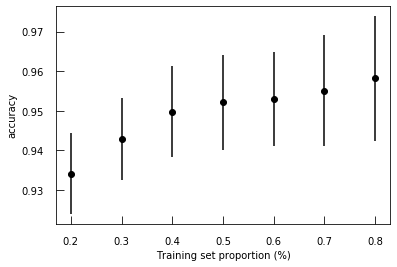

In [10]:
t = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

knn = KNeighborsClassifier(n_neighbors = 20, weights='uniform',n_jobs=-1)

plt.figure()

for s in t:

    scores = []
    for i in range(1,100):
        X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size = 1-s, stratify=y_cancer)
        scaler = StandardScaler() 
        scaler.fit(X_train) 

        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        knn.fit(X_train_scaled, y_train)
        scores.append(knn.score(X_test_scaled, y_test)) 
    plt.errorbar(s, np.mean(scores),yerr=np.std(scores),c='k',marker='o')

plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy');

### Hyper parameters

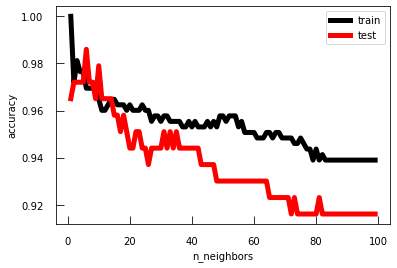

In [11]:
k_range = range(1,100)
scores_test = []
scores_train = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform',n_jobs=-1)
    knn.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(knn.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(knn.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
plt.xticks([0,20,40,60,80,100])
plt.legend(loc='best')
plt.show()

The train set accuracy decreases with the number of neighbors involved in the vote. For small values of n we are clearly overfitting : accuracy at one for the training set and a big drop in the accuracy of the test set.



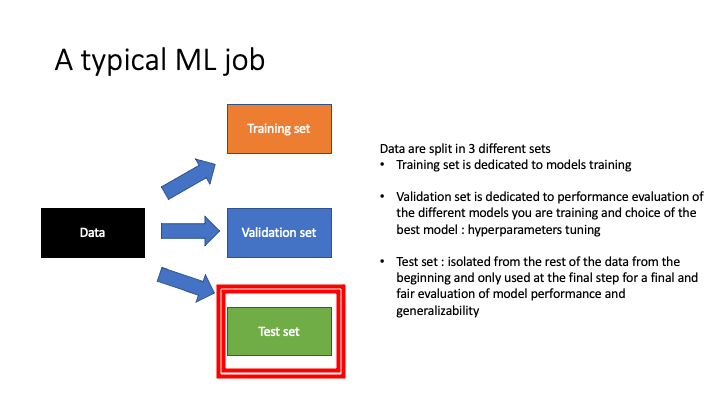

In [49]:
Image('../images/Presentation3.png')

If you have enough data, you should always split your dataset into two parts. The first part is used for training and hyper-parameter optimization via cross validation, the second (usually smaller part) is just used to test the optimized classifier. 

If your dataset is small, there may not be enough data for a test set and will only use cross validation.

Scikit learn provides a nice built in way to vary hyperparameters and pick the best ones, through the **GridSearchCV method**.

The CV in GridSearchCV refers to Cross Validation : it means that the training data is split multiple times into a training and validation set. Each model for which the different hyperparameters are varied is trained under a random subset of the training dataset and evaluated under the complementary subset of the training dataset. **For each hyperparameters set, this is done multiple times (typically 5 times: the training data is split in 5. 4 are used for training 1 for validation. Then you repeat 5 times so every subset has been a validation set at some point). You calculate the average score (the score can be the accuracy) from those multiple tries and take the best one.**

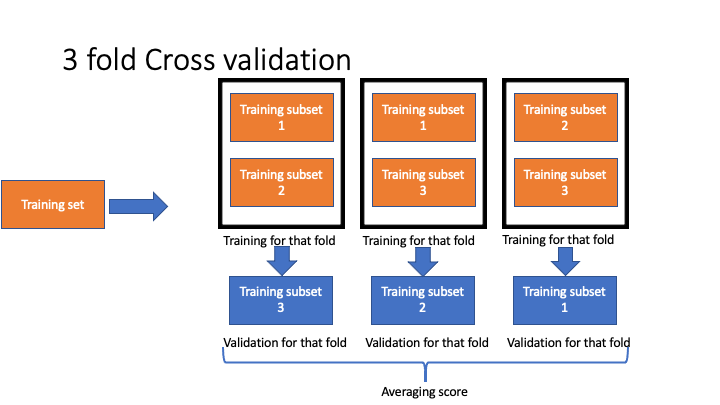

In [16]:
Image('../images/Presentation4.png')

Just like before when we were splitting data between test and training, we have to be careful that we don't have **data leakage between the training and validation sets**. Therefore operations like scaling of data or feature selection should only be done on the training set. How can we implement this in sklearn? 

**To do so we will have to create a pipeline : which is a scikit way to automatized tasks.**

In [12]:
from sklearn.pipeline import Pipeline

knn=KNeighborsClassifier(n_jobs=-1)

pipeline_knn=Pipeline([('scalar',StandardScaler()),('model',knn)])

from sklearn.model_selection import GridSearchCV

grid_values = {'model__n_neighbors': np.arange(5,50,1),'model__weights':['uniform','distance']}# define the hyperparameters you want to test
#with the range over which you want it to be tested. Notice the  double underscore? It allows to refer to a specific part of
#the pipeline, here the model.

grid_knn_acc = GridSearchCV(pipeline_knn, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be made

grid_knn_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_knn_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_knn_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_knn_acc.best_score_)#get the best score calculated from the training/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Grid best score (accuracy):  0.9647879616963065
Grid best parameter (max. accuracy) model on test:  0.972027972027972


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_test_c=grid_knn_acc.predict(X_cancer_test)

confusion_mc_c = confusion_matrix(y_cancer_test, y_pred_test_c)

confusion_c = pd.DataFrame(confusion_mc_c,columns=cancer['target_names'],index=cancer['target_names'])

print(confusion_c)

print("{0} out of {1} benign cell samples were classified as malignant".\
      format(confusion_mc_c[1,0],confusion_mc_c.sum(axis=1)[1]))
print("{0} out of {1} malignant cell sample were classified as benign".\
      format(confusion_mc_c[0,1],confusion_mc_c.sum(axis=1)[0]))

           malignant  benign
malignant         49       4
benign             0      90
0 out of 90 benign cell samples were classified as malignant
4 out of 53 malignant cell sample were classified as benign


**Congrats!!!! You just trained a classical machine learning model using best practice in term of scaling, hyperparameter choice, and data leakage.**


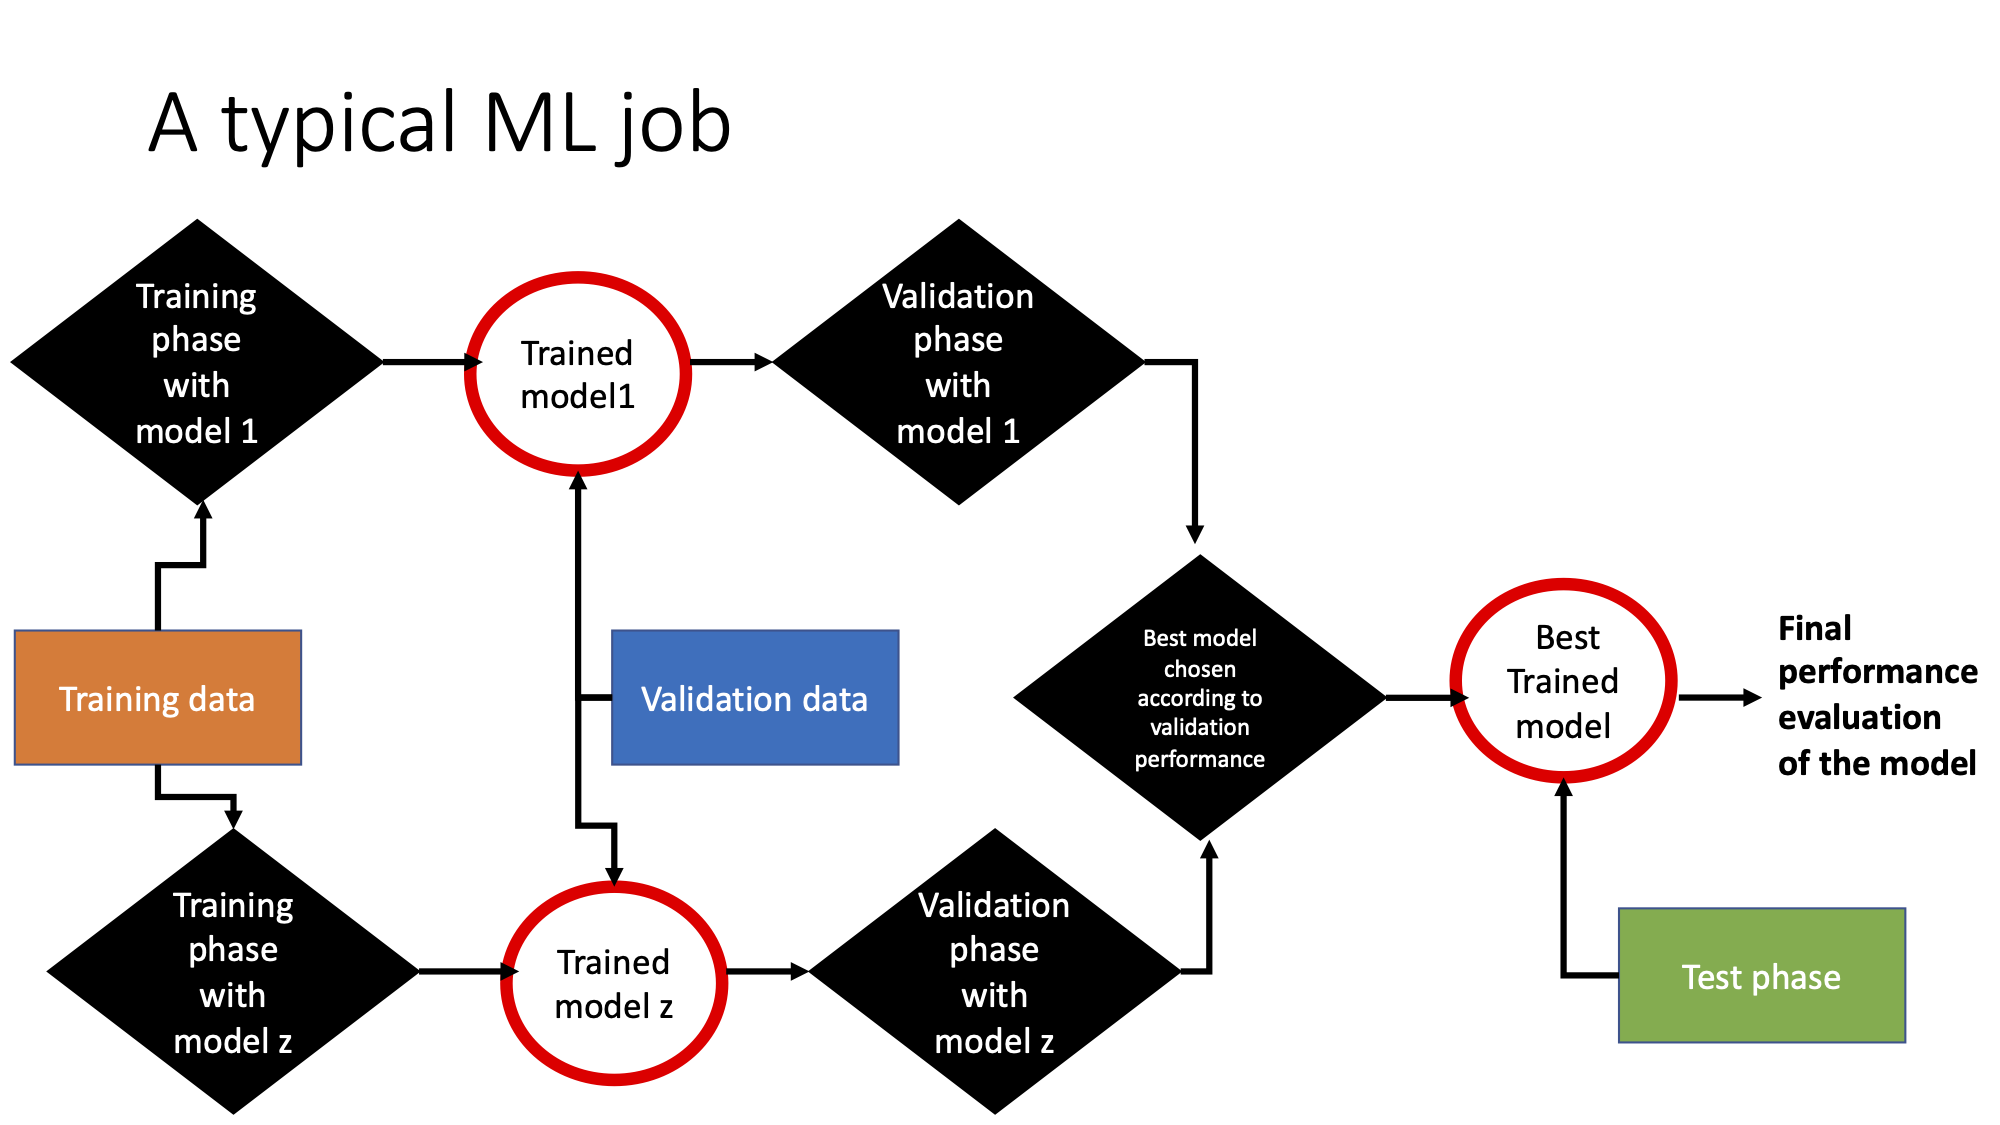

In [19]:
Image('../Images/Presentation2.png')

Now you might want to save your beautifull model so you can use it latter on , with new unknown data. For that you will need to.

Retrain your model on the full training set using the grid_knn_acc.best_params_ best hyperparamters found. 

Then **save your trained model using pickle**.

import pickle

pickle.dump(model, open(filename, 'wb'))


**if you want to load it again**

loaded_model = pickle.load(open(filename, 'rb'))

### Great we have a model but : **Was accuracy actually the metric we wanted to optimize on??**

Here we can see that eventhough our **accuracy is pretty good we are still missing 4 cancers**. In this particular case labelling a malignant tumor as begnin can have huge consequences. **The types of error are not symetrical** (we could live with predicting false positive, the patient will have to do further testing, but false negative is bad) : missing malignant tumors is grave and we could try to tune our model so that it has a lower rate of false negatives even if it means that we will predict more malignant tumors when they are actually begnin and that our accuracy might decrease. 

How do we tune our model??

Well we **could use another metric for evaluation** in GridSearchCV (ckeck GridSearchCV docu), a metric that looks more at one particular type of error instead of global accuracy. 

We could also change the decision threshold in the k-NN classifier. In order to do so we could calculate the probablity for a class using the predict_proba(X) function and use a threshold different from 0.5 for classification.


**Before moving to another method let's apply what we just used to the multiclass data : Iris**. Right now you might wonder why i am introducing another dataset here. Well simply because having multi classes instead of two clasess makes quite a bit of difference for the algo. It will not be obvious right now but when we will start looking into ROC_AUC, you will see what I mean. So for now let's just enjoy doing the same as before but for a multiclass dataset. 

### Iris dataset <a class="anchor" id="MC-KN"></a>

In [14]:
from sklearn.pipeline import Pipeline

X_iris_train, X_iris_test, y_iris_train, y_iris_test = \
    train_test_split(X_iris, y_iris,random_state=2,stratify=y_iris)

knn_i=KNeighborsClassifier()

pipeline_knn_i=Pipeline([('scalar',StandardScaler()),('model',knn_i)])

from sklearn.model_selection import GridSearchCV

grid_values = {'model__n_neighbors': np.arange(5,20,1),'model__weights':['uniform','distance']}
# define the hyperparameters you want to test with the range over which you want it to be tested.

grid_knn_i_acc_i = GridSearchCV(pipeline_knn_i, param_grid = grid_values, scoring='accuracy')
#Feed it to the GridSearchCV with the right score over which the decision should be taken

grid_knn_i_acc_i.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc_i=grid_knn_i_acc_i.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_knn_i_acc_i.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_knn_i_acc_i.best_score_)#get the best score calculated from the training/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc_i)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__n_neighbors': 7, 'model__weights': 'distance'}
Grid best score (accuracy):  0.9553359683794467
Grid best parameter (max. accuracy) model on test:  1.0


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_test_i=grid_knn_i_acc_i.predict(X_iris_test)

confusion_mc_i = confusion_matrix(y_iris_test, y_pred_test_i)

confusion_i = pd.DataFrame(confusion_mc_i,columns=iris['target_names'],index=iris['target_names'])

print(confusion_i)

            setosa  versicolor  virginica
setosa          13           0          0
versicolor       0          13          0
virginica        0           0         12


# Logistic regression <a class="anchor" id="Logistic-regression"></a>

**The main hypothesis of logistic regression is that the log odds ratio of the probability that a point is part of a certain class follows a linear combination of the features describing this point.** This is equivalent to the assumption that the two classes are linearly separable and that the log odds ratio increases linearly with the distance from the separating line.

Let's say you only have two classes and so your target variable can only take two values $y_{i} \in\{1,0\}$. Let's define $p(\pmb{x})=P(y=1)$ the probability than your datapoint $\pmb{x}$ belongs to class 1. Let's also say that you have $M$ features to describe a point $\{\pmb{x}_{i}\}_{i=1,...,M}$. And that you have N points.

Then we make the hypothesis that:

$log{\frac{p}{1-p}}=w_{0}+\Sigma^{M}_{i=1}w_{i}x_{i}=w_{0}+\pmb{x}\cdot\pmb{w}$

which translates to

$p(\pmb{x}|y=1)=\frac{1}{1+e^{-(w_{0}+\pmb{x}\cdot\pmb{w})}}$  

**So the probability that your datapoint is in class 1 is the logistic function (sigmoid) applied to the linear combination of features.** The larger the weights $\pmb{w}$ the steeper the change between the two classes. The values of $\pmb{w}$ are stored by the 'coeff_' attribute of the [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class. $w_{0}$ is stored in 'intercept_'. The function 'decision_function($\pmb{x}$)' returns $w_{0}+\pmb{x}\cdot\pmb{w}$ and 'predict_proba($\pmb{x}$)' returns $p(\pmb{x}|y=1)$ and $p(\pmb{x}|y=0)$

Unlike KNN the logistic regression model provides valuable information on the importance of features for the classification. The bigger the absolute value of the weight $w_{i}$ associated with a feature, the more important this feature is to discriminate between your classes (supposed that features are normalized and mapped onto a similar scale).

Fitting a logistic regression model corresponds to optimizing the loss function

$\pmb{w},w_{0}=argmin_{\pmb{w},w_{0}}\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})$
<br><br>
$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y})=\Sigma^{N}_{i=1}y_{i}\log(p(\pmb{x}_i|y=1))+(1-y_{i})\log(p(\pmb{x}_i|y=0))$

So, now the way we get the w is from fitting our distribution of probability that a point is in class 1. If the number of features is high and there is a significant amount of non-informative features, the fitting procedure can become unstable. What happens is that some weights of non-informative features may become very large in order to minimize the loss function on the training data, which may lead to reduced performance on the test data (overfitting).

In order to avoid this situation we can add a penalty to the loss function that avoids that weights $w_{i}$ become too large. In ML three such penalties are commonly used:

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}|w_{i}|$ , l1 regularization (Lasso) C being the inverse of the weight that you put on that regularization 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}w_{i}^{2}$ , l2 regularization (Ridge) 

$\mathcal{L}(\pmb{w},w_{0},\pmb{X},\pmb{y}) + \frac{1}{C}\Sigma^{N}_{i=1}(\alpha|w_{i}|+(1-\alpha)w_{i}^{2})$ , elasticnet

For a deeper understanding of those notions :

https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a


The l1 (lasso) regularization produces many zero weights. It is useful for the case where you suspect that only a few features are informative. l2 (ridge) regularization leads to many features with small, but non-zero weights. The l1 regularization may have more bias, and the l2 more variance. The elasticnet interpolates between these two situations at the cost of having and additional parameter $\alpha$.



/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


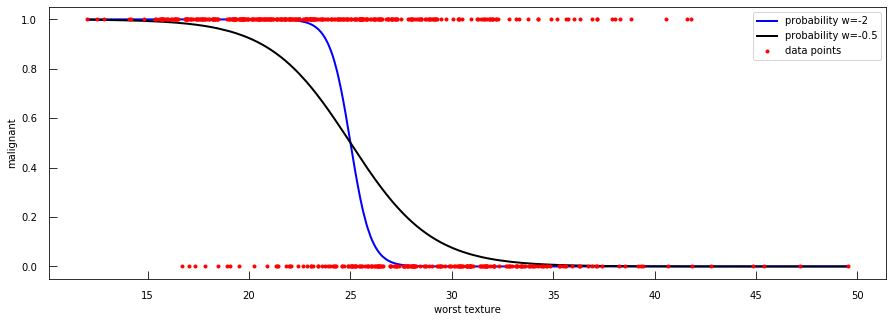

In [16]:
x = df_cancer['worst texture']
y = df_cancer['malignant']

idx = np.argsort(x)
x = x[idx]
y = y[idx]
p1 = np.reciprocal(1+np.exp(-(-2*x+50)))
p2 = np.reciprocal(1+np.exp(-(-x/2+12.5)))

plt.figure(figsize=(15,5))
plt.xlabel('worst texture')
plt.ylabel('malignant')
plt.plot(x, p1,'b-',linewidth=2,label='probability w=-2')
plt.plot(x, p2,'k-',linewidth=2,label='probability w=-0.5')
plt.plot(x, y,'r.',linewidth=5,label='data points')
plt.legend(loc='best')
plt.show()

#### Toy dataset : introduction to AUC ROC <a class="anchor" id="AUC-ROC"></a>

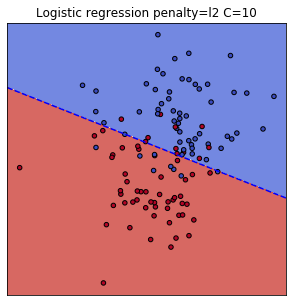

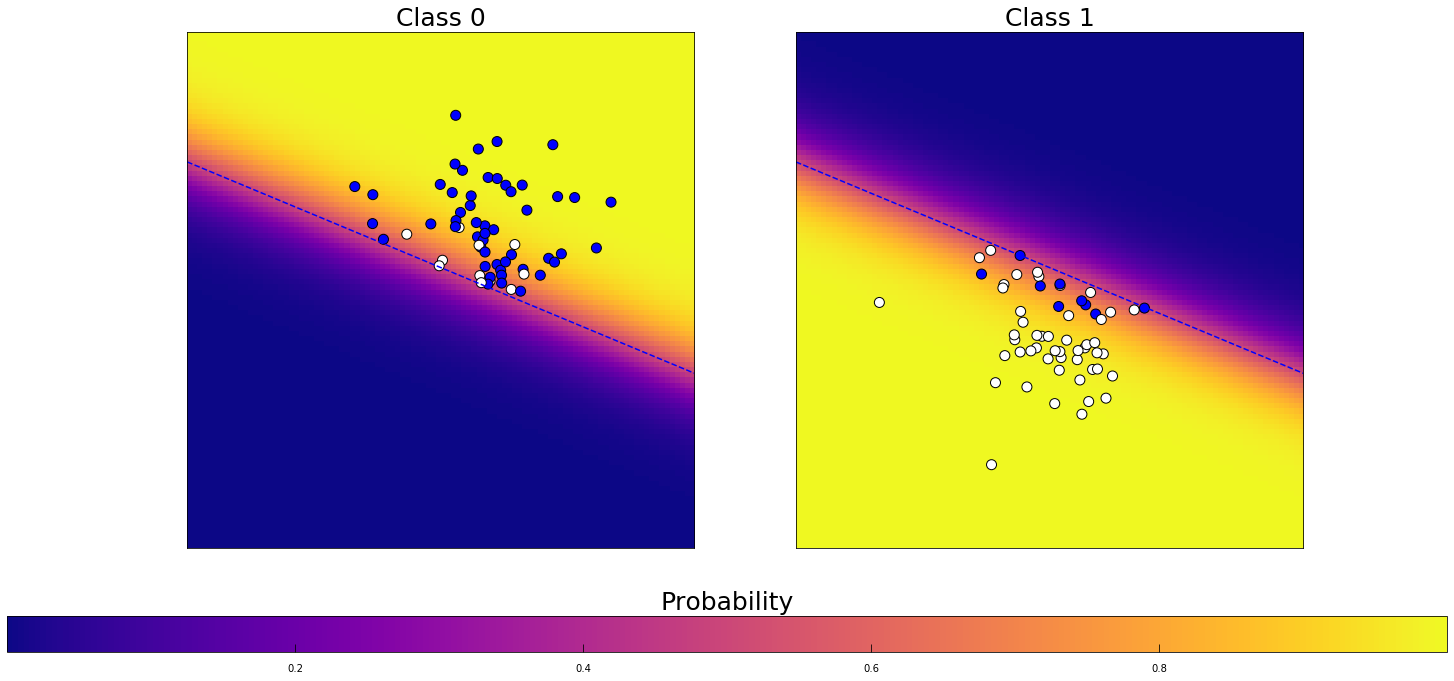

/Users/markusmueller/Documents/Teaching/SIB/ML/git/intro-machine-learning-training/python_notebooks/utils.py:253: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


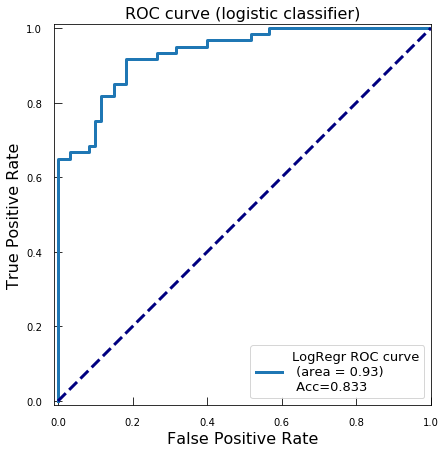

In [17]:
from sklearn.datasets import make_blobs
from utils import countour_lr
X_toy_2, y_toy_2 = make_blobs(n_samples=120, centers=2,cluster_std=3, random_state=6)

countour_lr('l2',X_toy_2, y_toy_2,10,'ovr')

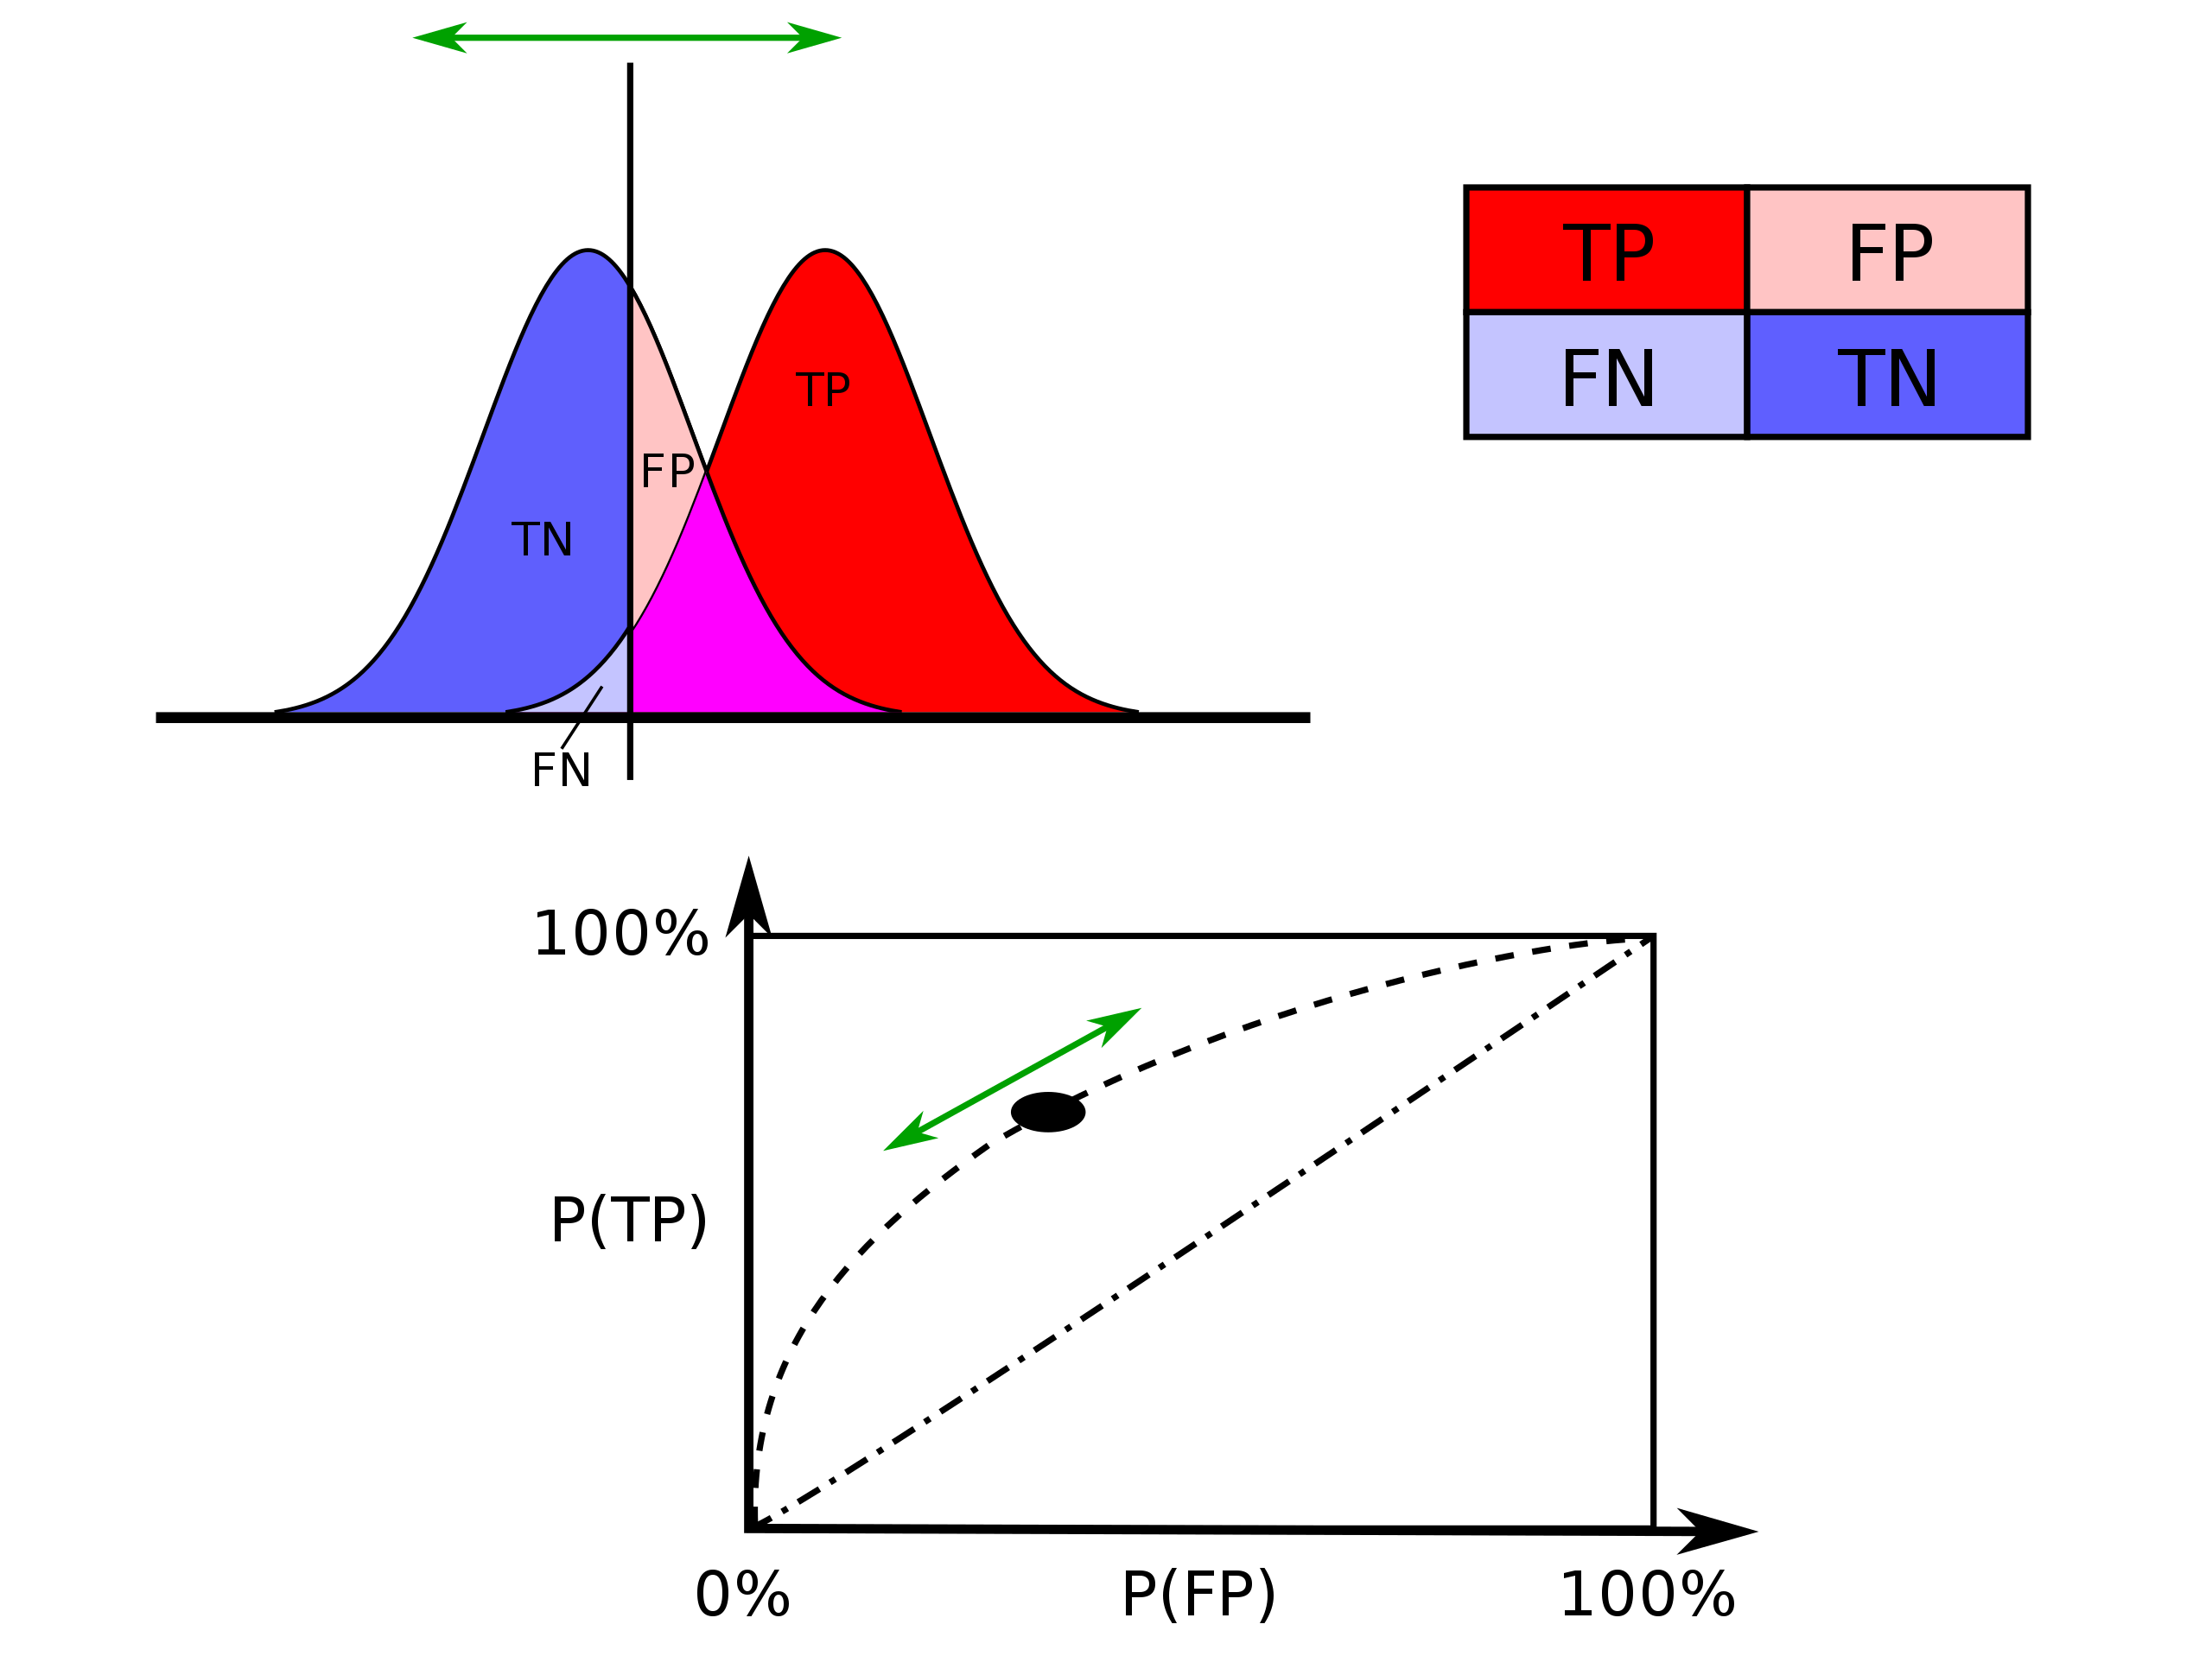

In [120]:
Image("../Images/Chapter_2_ROC_curves.png") #from wikipedia

From how we introduced logistic regression before you can already see that an hyperplane share the same probability. What is represented in the first panel is one particular hyperplane (here a line in dimension 2) **for which the probability to be part of one of the two groups is >0.5**. But actually that **is quite an arbitrary threshold**. The second panel of plots shows you **many of those different hyperplanes having different probabilities and you could in principle choose any of those lines for class delimitation.**

**But why would you do that? Well for example if you want to tune how stringent you want to be towards different error types.** As before, if you deal with deciding if the patient you have in front of you should go for more exams because of a suspicion of malignant tumor, you don't want to miss any of those malignant tumors. It doesn't really matter if in the process you send many clean patient for further exam. So maybe in that case having a 0.5 threshold for malignant tumor calling is too stringent.

**A way to visualize those type of problem is to look at the receiver operating curve (ROC). In this curve each point is a particular threshold and its coordinate are how much False positive and True positive this threshold will create.**

$FPR= \frac{FP}{FP+TN}$

$TPR= \frac{TP}{TP+FN}$

**Ideally you want a curve that perfectly follows the edge of the square** : whatever threshold you use you recover all the postive and the negative samples. So the best model should have an area under the curve of 1.  In reality the curve that you will get ressemble more to the one from the third panel.

There is one more thing that I would like to add here, which makes this story about ROC curve and caring about the right metric even more important. **The diagonal line in the ROC curve represents what is called a dummy classifier. It is a classifier that has learned only the probabilities to have one class instead of the other. The farther you are from that line the better you are (so the more area under the curve)**. Those comparisons to dummy classifier are really important when your dataset is imbalanced. Imagine the extreme case of a dataset made of 99 class 0 and 1 class 1. In that case your basal accuracy is going to be 98% : but that doesn't make your model good. It just means that it has chosen randomly 99 point to class as 0 and 1 to class as 1. **It is a bad model eventhough it has a high accuracy. The ROC AUC is sensitive to that**. So if you have imbalanced dataset use scoring that are sensitive to it. There are other ways to deal with it like weighting labels differently in the loss function. We will spend a little bit more time on the subject of imbalanced datasets in [Using AUC ROC to recognize artifact from unbalanced dataset](#Unbalanced), but not much. Just know that this problem exists and understand what it does through later on examples. Always check if your dataset is imbalanced or not and if it some classifier have built in functions to face that: logistic regression and SVC for example offer the use of the class_weight argument.

On the ROC curve can you find in which direction the thresholds are getting bigger?

### Breast cancer dataset  <a class="anchor" id="LR-hyper"></a>

In [18]:
lr = LogisticRegression(penalty='none')
lr.fit(X_cancer_train_scaled, y_cancer_train)

y_pred_test_scaled=lr.predict(X_cancer_test_scaled)

y_pred_train_scaled=lr.predict(X_cancer_train_scaled)

print('none: Acc= {0:.3f} on scaled train, Acc= {1:.3f} on scaled test'.format(lr.score(X_cancer_train_scaled,y_cancer_train),\
                                                           lr.score(X_cancer_test_scaled,y_cancer_test)))

none: Acc= 1.000 on scaled train, Acc= 0.958 on scaled test


/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


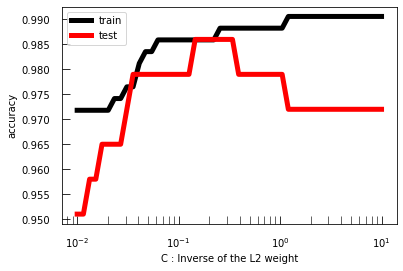

In [19]:
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l2',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L2 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

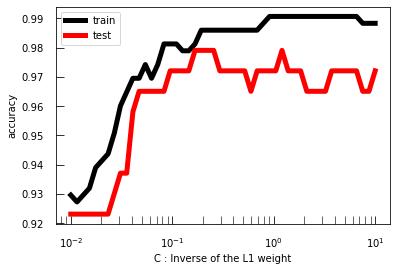

In [20]:
k_range = np.logspace(-2,1,50)
scores_test=[]
scores_train=[]

for k in k_range:
    logi_r = LogisticRegression(penalty='l1',C=k,solver='liblinear')
    logi_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(logi_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(logi_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('C : Inverse of the L1 weight')
plt.ylabel('accuracy')
plt.plot(k_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(k_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

Whatever the penalty norm is, we observe the same thing. **Train and test accuracy increase together with the inverse of the norm weight: starting from too much regularization we are not actually fitting our data at first.... At some point we see the overfitting rising: test accuracy drops while train accuracy flatten at a perfect 1. This makes sense: we add a penalty to avoid overfitting and going to the right side of the graph we reduce this counter measure. We can see here that there is indeed an optimal value, in between of those two extremes, for the strenght of our regularization.**

That penalty is tuned by the type of norm we are using but also by a scalar. Here we represent the scalar by its inverse... So the more we go on the right side of the plot the less we counter overfitting. But if we are too much on the left side of plot then the penalty is too big and it becomes difficult to fit our data! 

In [24]:
logi_r=LogisticRegression()

pipeline_lr=Pipeline([('scalar',StandardScaler()), ('model',logi_r)])

from sklearn.model_selection import GridSearchCV

grid_values = {'model__C': np.logspace(-2,1,50),'model__penalty':['l1','l2','elasticnet']}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score(here accuracy) over which the decision should be taken

grid_lr_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_lr_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__C': 1.0481131341546852, 'model__penalty': 'l2'}
Grid best score (accuracy):  0.9812038303693571
Grid best parameter (max. accuracy) model on test:  0.9790209790209791


/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.95534884        nan        nan 0.9529959         nan
        nan 0.9529959         nan        nan 0.9529959         nan
        nan 0.9529959         nan        nan 0.9529959         nan
        nan 0.95532148        nan        nan 0.95767442        nan
        nan 0.96002736        nan        nan 0.9623803         nan
        nan 0.96473324        nan        nan 0.96708618        nan
        nan 0.96943912        nan        nan 0.96943912        nan
        nan 0.96711354        nan        nan 0.96711354        nan
        nan 0.96711354        nan        nan 0.96711354        nan
        nan 0.96946648        nan        nan 0.96946648        nan
        nan 0.96946648        nan        nan 0.96946648        nan
        nan 0.97652531        nan        nan 0.97652531        nan
        nan 0.97885089        nan

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
y_pred_test_c=grid_lr_acc.predict(X_cancer_test)

cm = confusion_matrix(y_cancer_test, y_pred_test_c)

cdf = pd.DataFrame(cm,columns=cancer['target_names'],index=cancer['target_names'])

print(cdf)


           malignant  benign
malignant         52       1
benign             2      88


Let's check how the model actually discriminates the two classes with the code below. Or said differently : what can we learn from our model a part from pure classification.

In [49]:
from operator import itemgetter
lr = LogisticRegression(penalty=grid_lr_acc.best_params_['model__penalty'],C=grid_lr_acc.best_params_['model__C'])
lr.fit(X_cancer_train_scaled, y_cancer_train)
w=lr.coef_[0]#get the weights

sorted_features=sorted([[cancer['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df


Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,radius error,1.216919
1,worst texture,1.159287
2,worst area,1.003304
3,area error,0.985328
4,worst radius,0.960926
5,worst symmetry,0.914690
6,worst concave points,0.913693
7,compactness error,0.833672
8,worst concavity,0.745356
9,worst perimeter,0.716742


### Imbalanced classes and class weights <a class="anchor" id="Unbalanced"></a>

In [27]:
# load immunology data of notebook 1
df_im = pd.read_csv('../data/aaf2288-Table-S8.csv',header=0)

CD8_info = df_im["CD8+ T cell response induced in healthy donor: Tested/Observed"]
response = np.full(df_im.shape[0],-1)
response[CD8_info.notna() & CD8_info.str.contains("YES /")] = 0
response[CD8_info.notna() & CD8_info.str.contains("/ YES")] = 1

df_im.loc[response==1,'Mutant peptide'] = df_im.loc[response==1,'Mutant peptide']+"*"

# select the numerical features
X_im = df_im[["Position of mutation in peptide","Predicted affinity wildtype peptide (nM)",
              "Predicted affinity mutant peptide (nM)","Predicted cleavage probability wildtype peptide",
              "Predicted cleavage probability mutant peptide","Predicted stability wildtype peptide (hours)",
              "Predicted stability mutant peptide (hours)","% of mutant reads","RNA expression of gene (FPKM)"]]

d = {"Position of mutation in peptide":"MUT_pos",
     "Predicted affinity wildtype peptide (nM)":"WT_affin",
     "Predicted affinity mutant peptide (nM)":"MUT_affin",
     "Predicted cleavage probability wildtype peptide":"WT_cleav",
     "Predicted cleavage probability mutant peptide":"MUT_cleav",
     "Predicted stability wildtype peptide (hours)":"WT_stability",
     "Predicted stability mutant peptide (hours)":"MUT_stability",
     "% of mutant reads":"WT_read_perc",
     "RNA expression of gene (FPKM)":"RNA_expr"}

X_im = X_im.rename(columns = d, inplace = False) # rename the columns
# some features have highly skewed distributions and its better to normalize them by a log-transform
X_im['RNA_expr'] = np.log10(X_im['RNA_expr'])
X_im['WT_affin'] = np.log10(X_im['WT_affin'])
X_im['MUT_affin'] = np.log10(X_im['MUT_affin'])

# select the numerical features

X_im = X_im.set_index(df_im['Mutant peptide'], inplace=False)

X_im = X_im[response>=0]
y_im = response[response>=0]


In [28]:
lr_im = LogisticRegression('l2',C=10)
lr_im.fit(X_im, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["negative","positive"])

print("No class weights")
print(cdf)

No class weights
          negative  positive
negative        43         2
positive         7         4


/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [29]:
lr_im = LogisticRegression('l2',C=10,class_weight='balanced')
lr_im.fit(X_im, y_im)

#no CV here, which is a bad idea. But here we make an exception since the dataset is very small
# and we are only interested in the effect of the class weight on training
y_pred = lr_im.predict(X_im)

cm = confusion_matrix(y_im, y_pred)

cdf = pd.DataFrame(cm,columns=["negative","positive"],index=["negative","positive"])

print("Balanced class weights")
print(cdf)

Balanced class weights
          negative  positive
negative        37         8
positive         3         8


/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Imbalanced dataset and performance metrics

In [30]:
X2_i, y2_i = make_blobs(n_samples=(500,50), centers=[[1,1],[1,1]], random_state=6)

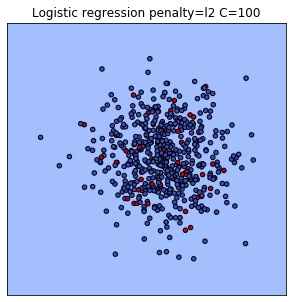

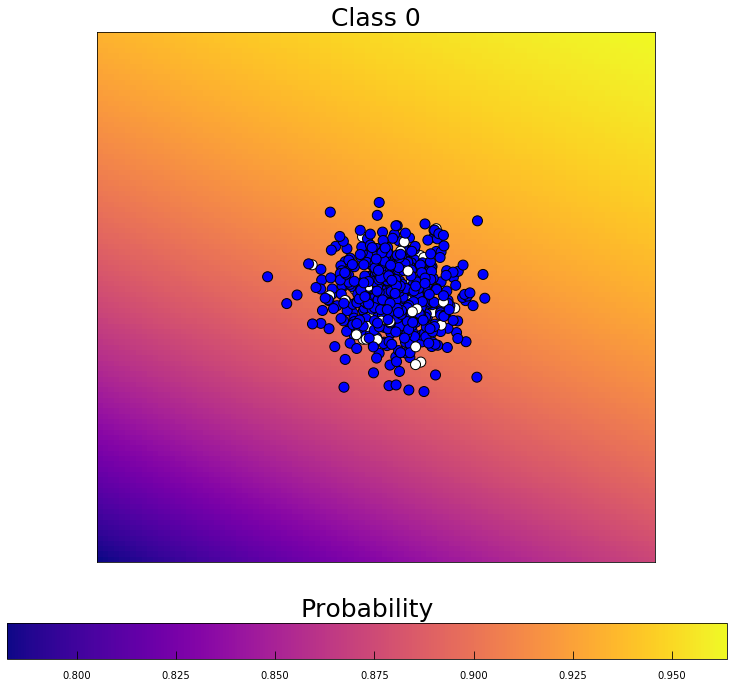

/Users/markusmueller/Documents/Teaching/SIB/ML/git/intro-machine-learning-training/python_notebooks/utils.py:253: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


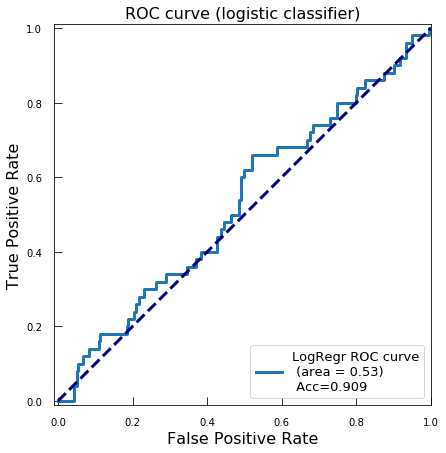

In [31]:
countour_lr('l2',X2_i,y2_i,100,'ovr')

**As you can see here the data was not separable from the beginning**. But just because the dataset was imbalanced (500 of one class and only 50 of the other) and we trained our model on accuracy score **we still get a good accuracy**. But this is missleading, our model is not usefull right now, it is randomly assigning labels according to the statistics of the labels. Again, accuracy is informative but doesn't hold all the information.

Also, because of how this metric is built it gives the same importance in its calculation to both classes. I fyou would like to focus on your ability to detect class 1 rather than 0 use the precision recal curve :

Precision : $\frac{\bf{TP}}{\bf{TP}+\bf{FP}}$

Recall : $\frac{\bf{TP}}{\bf{TP}+\bf{FN}}$

You will see how it looks in the following paragraphes, just remember that just like before this method estimate statistics (here precision and recall) over different decision threshold. You can summurize the goodness of the model with one number just like before : the average precision. We will see that later on 


If you don't feel like going through different scoring (i.e. accuracy), you can compare your model to a dummy classifier that will either only learn the statistic of your training set or always answer the most probable class (other dummy classifier are available): sklearn.dummy.DummyClassifier

/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


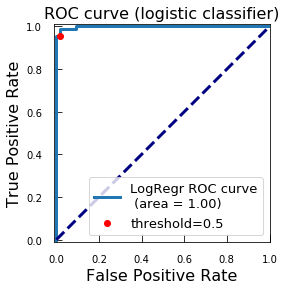

In [32]:
import scipy as sc
# this three lines here are how you get the area under the ROC curve score which is very important for evaluating your model
y_score_lr_c = grid_lr_acc.decision_function(X_cancer_test)#decision_function gives you the proba for a point to be in
# a class
fpr_lr_c, tpr_lr_c, thre = roc_curve(y_cancer_test, y_score_lr_c)# this calculates the ROC curve
roc_auc_lr_c = auc(fpr_lr_c, tpr_lr_c)#finally this calculates the area under the curve

keep = -1
proba=sc.special.expit(thre)
for i in range(len(proba)-1):
    if (proba[i]-0.5)*(proba[i+1]-0.5) <= 0:
        keep=i
        break
        

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr_c, tpr_lr_c, lw=3, label='LogRegr ROC curve\n (area = {:0.2f})'.format(roc_auc_lr_c))
plt.plot(fpr_lr_c[keep], tpr_lr_c[keep],'ro',label='threshold=0.5')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (logistic classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

From the plot above we see that putting our decision threshold to 0.5 to discriminate between cancer and non cancer lead to missing 2 or 3 % of the cancer. **So maybe a better threshold should be a lower one that will put our red dot on the right side of the curve, optimally exactly were you have a TPR of one and a FPR around 0.15.**

Scikit learn allows you to directly plot those curves 

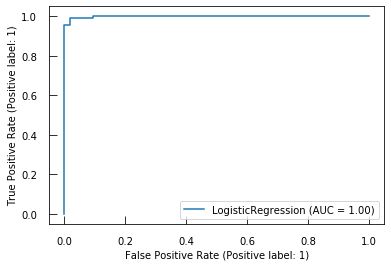

In [50]:
plot_roc_curve(lr,X_cancer_test_scaled, y_cancer_test)

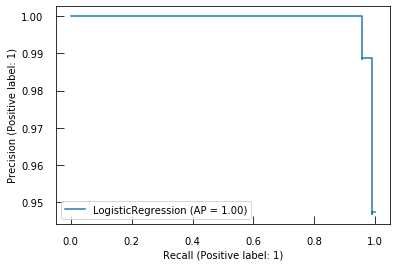

In [51]:
#Precision recall curve : AP = Average Precision
plot_precision_recall_curve(lr,X_cancer_test_scaled, y_cancer_test)

$\text{AP} = \sum_n (R_n - R_{n-1}) P_n$

where $R_n$ is recall at threshold n and $P_n$ is precision at threshold n

So AP (Avergae precision) is the weighted average over all the threshold of the precision relative to the difference of recall between two thresholds

Or you can code it yourself

/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


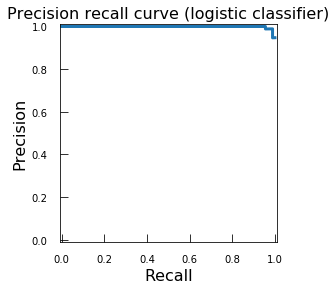

In [118]:
y_score_lr_c = grid_lr_acc.decision_function(X_cancer_test)#decision_function gives you the proba for a point to be in
# a class
prec_lr_c, rec_lr_c, thre = precision_recall_curve(y_cancer_test, y_score_lr_c)# this calculates the ROC curve

plt.figure()
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.plot(rec_lr_c, prec_lr_c, lw=3)

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title('Precision recall curve (logistic classifier)', fontsize=16)

plt.axes().set_aspect('equal')
plt.show()

In [42]:
#Those are the other scores (other than accuracy and roc_auc) to evaluate the performence of your model.
#If you recall we used scoring=accuracy in our GridSearchCV. But we could use another metric.
from sklearn.metrics import SCORERS
for i in sorted(list(SCORERS.keys())):
    print(i)

accuracy
adjusted_mutual_info_score
adjusted_rand_score
average_precision
balanced_accuracy
completeness_score
explained_variance
f1
f1_macro
f1_micro
f1_samples
f1_weighted
fowlkes_mallows_score
homogeneity_score
jaccard
jaccard_macro
jaccard_micro
jaccard_samples
jaccard_weighted
max_error
mutual_info_score
neg_brier_score
neg_log_loss
neg_mean_absolute_error
neg_mean_absolute_percentage_error
neg_mean_gamma_deviance
neg_mean_poisson_deviance
neg_mean_squared_error
neg_mean_squared_log_error
neg_median_absolute_error
neg_root_mean_squared_error
normalized_mutual_info_score
precision
precision_macro
precision_micro
precision_samples
precision_weighted
r2
rand_score
recall
recall_macro
recall_micro
recall_samples
recall_weighted
roc_auc
roc_auc_ovo
roc_auc_ovo_weighted
roc_auc_ovr
roc_auc_ovr_weighted
top_k_accuracy
v_measure_score


## Multiclass case: Iris data set <a class="anchor" id="LR-IRIS"></a>

In [52]:
grid_values = {'model__C': np.logspace(-2,1,50),'model__penalty':['l1','l2'],'model__solver':['liblinear']}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc_i = GridSearchCV(pipeline_lr, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score over which the decision should be taken

grid_lr_acc_i.fit(X_iris_train, y_iris_train)

y_decision_fn_scores_acc_i=grid_lr_acc_i.score(X_iris_test,y_iris_test)

print('Grid best parameter (max. accuracy): ', grid_lr_acc_i.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc_i.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc_i)# get the equivalent score on the test
#dataset : again this is the important metric

y_pred_test_i=grid_lr_acc_i.predict(X_iris_test)

cm = confusion_matrix(y_iris_test, y_pred_test_i)

cdf = pd.DataFrame(cm,columns=iris['target_names'],index=iris['target_names'])

print(cdf)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6)}

In [53]:
scaler = StandardScaler() 
scaler.fit(X_iris_train)# the scaler is fit only on the train data!!!!!!!! 

X_iris_train_scaled = scaler.transform(X_iris_train)# you should always rescaled data after the splitting, 
X_iris_test_scaled = scaler.transform(X_iris_test)

lr = LogisticRegression(penalty=grid_lr_acc_i.best_params_['model__penalty'],C=grid_lr_acc_i.best_params_['model__C'],
                       solver=grid_lr_acc_i.best_params_['model__solver'],n_jobs=1)
lr.fit(X_iris_train_scaled, y_iris_train)
w=lr.coef_[0]#get the weights

sorted_features=sorted([[iris['feature_names'][i],abs(w[i])] for i in range(len(w))],key=itemgetter(1),reverse=True)

print('Features sorted per importance in discriminative process')
soted_feature_df=pd.DataFrame(sorted_features,columns=['feature','abs contribution to the model'])
soted_feature_df

Features sorted per importance in discriminative process


,feature,abs contribution to the model
0,petal length (cm),4.022497
1,petal width (cm),1.746830
2,sepal width (cm),1.371895
3,sepal length (cm),0.000000


# Support Vector Machine (SVM) <a class="anchor" id="SVM"></a>

The basic principle of SVM is pretty simple. SVM aims to find the maximal margin hyperplane to separate data from different classes. The intuition behind the SVM is very geometrical even though it can be mapped to a probablistic formulation similar to logistic regression.

You want to maximize the margin separating the two classes. This margin is $\frac{2}{||\pmb{w}||}$. So you want to minimize $||\pmb{w}||$. The SVM loss function we want to minimize with respect to $\pmb{w}$ and $b$ is:


$C\cdot\Sigma^{N}_{i=1}\zeta_i + \frac{1}{2}||\pmb{w}||^{2}$ subject to $\zeta_i \ge 0$ and $y_{i}(w^{T}x_{i}-b) \ge 1-\zeta_i$, where $\zeta_i = \Sigma^{N}_{i=1}max(0,1-y_{i}(\pmb{w}\cdot\pmb{x}_i-b))$
 * $y_i$ is $-1$ or $1$ depending on the class of the point $i$
 * the class of point $\pmb{x}$ is determined by the SVM using the sign of $(\pmb{w}\cdot\pmb{x}-b)$ (ie, on which side of the $(\pmb{w}\cdot\pmb{x}-b)$ hyperplane we are).

The dual form of the loss function is:

$\Sigma^{N}_{i=1}\alpha_i - \frac{1}{2}\Sigma^{N}_{i=1}\Sigma^{N}_{j=1}\alpha_i\alpha_jy_iy_j\pmb{x}_i\cdot\pmb{x}_j$
subject to: $0 \le \alpha_i \le C$ and $\Sigma^{N}_{i=1}\alpha_iy_i = 0$

You can see that there is a - [dot product](https://en.wikipedia.org/wiki/Dot_product) involved : in the case of a linear hyperplane this dot product is just the cartesian dot product. It allows you to calculate distances between points in that cartesian space or between points and hyperplanes.

**So in principle you could use other definitions of distance between points to answer that classification question**. This is what non-linear SVM does and this is why you can choose different so called kernels as hyperparameters as we will see below :

$\pmb{x_{i}}\cdot\pmb{x_{j}}$ : cartesian

$(\gamma\pmb{x}_i\cdot\pmb{x}_j + r)^{d}$ : polynomial degree d

$exp(-\gamma||\pmb{x_{i}}-\pmb{x_{j}}||^{2})$ : gaussian radial basis

$tanh(\kappa\pmb{x_{i}}.\pmb{x_{j}}+c)$ : hyperbolic tangent

This is really powerful for classification but going non-linear by using a kernel trick prevents you to interpret how your features straight foreardly. If you want to get information about the feature importance from a non-linear SVM, you need to follow a leave-one-out strategy.



### Toy data : linear kernel <a class="anchor" id="SVM-linear"></a>

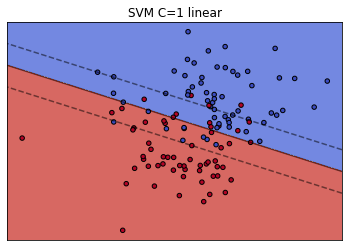

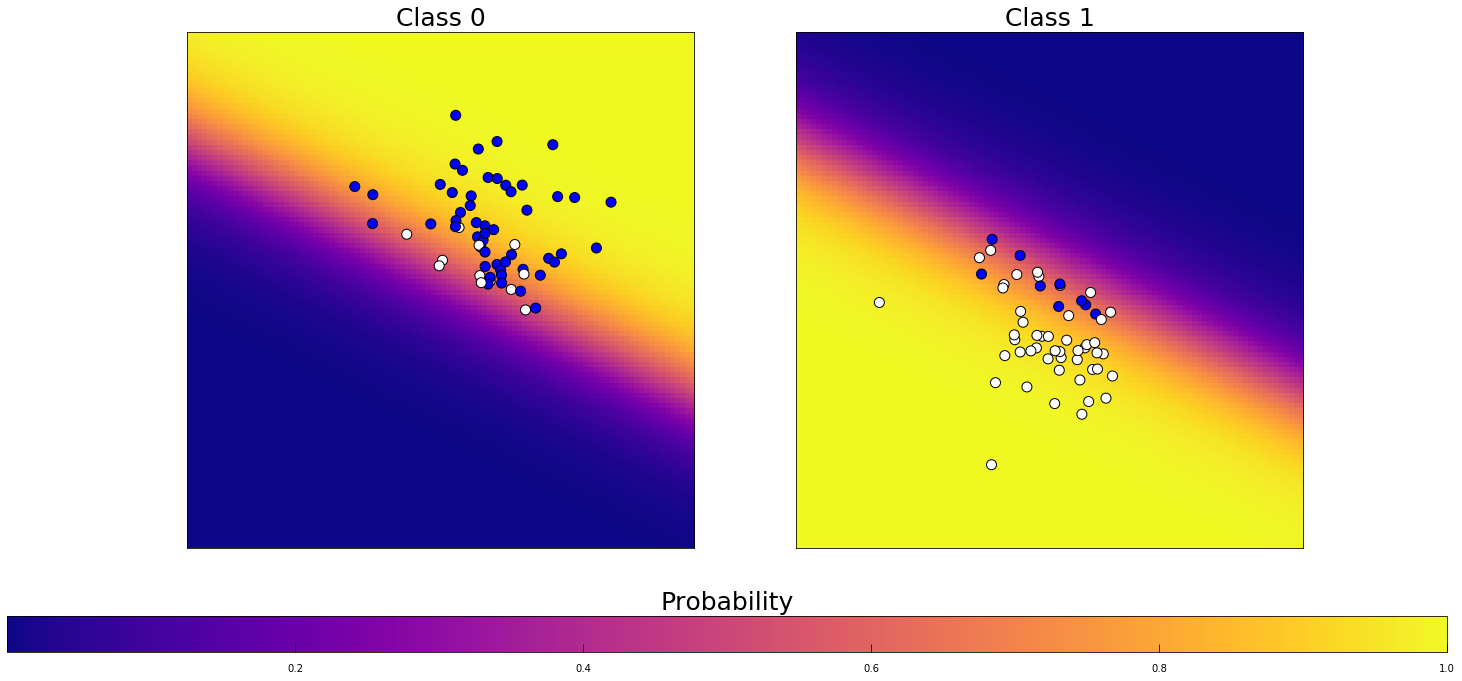

/Users/markusmueller/Documents/Teaching/SIB/ML/git/intro-machine-learning-training/python_notebooks/utils.py:563: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


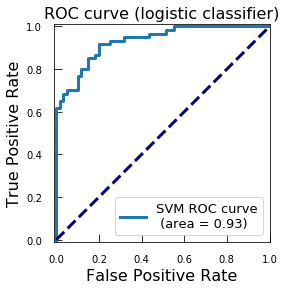

In [53]:
from utils import countour_SVM

#2 classes
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
countour_SVM(X_toy_2,y_toy_2,1,'linear',2,1,'ovr')

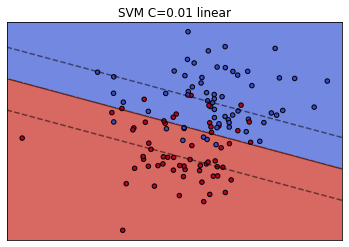

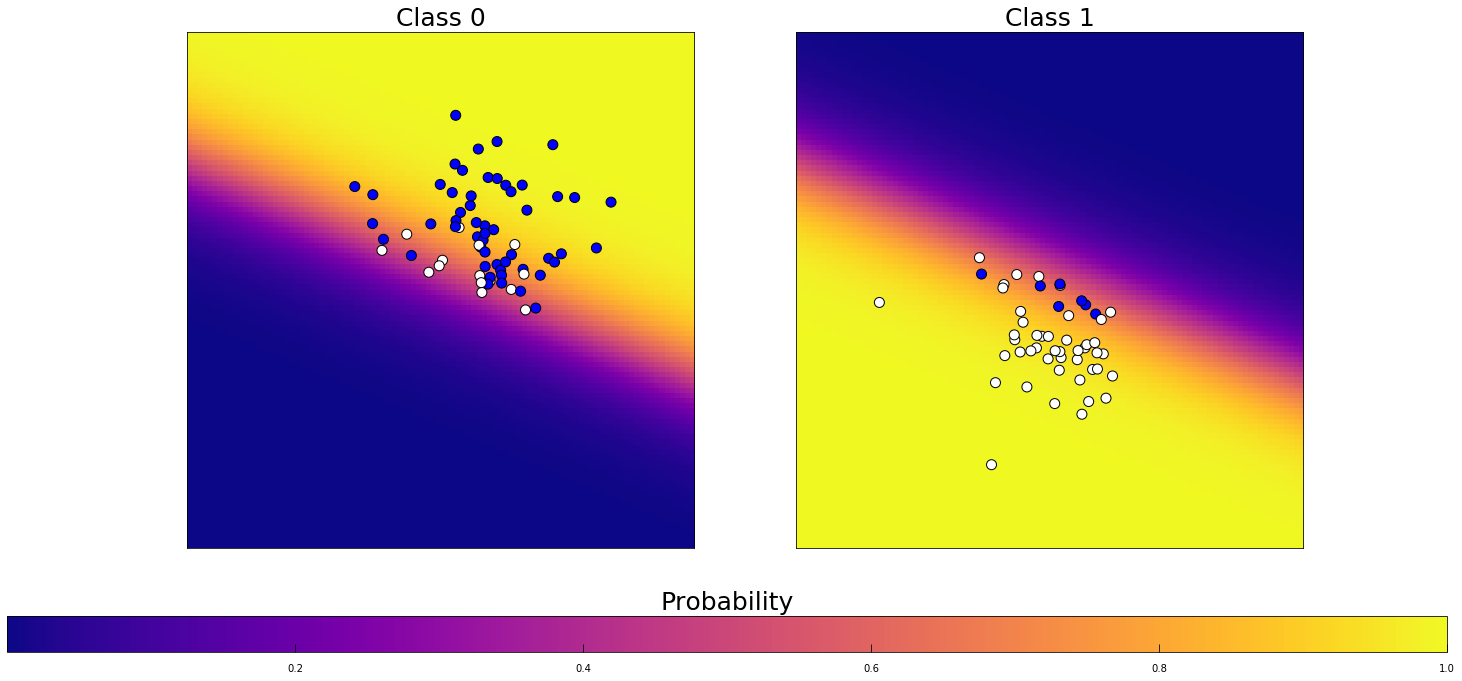

/Users/markusmueller/Documents/Teaching/SIB/ML/git/intro-machine-learning-training/python_notebooks/utils.py:563: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


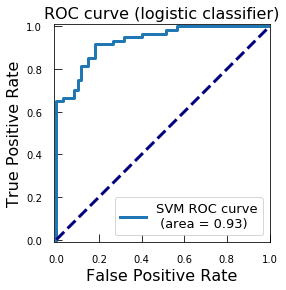

In [54]:
#2 classes
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
countour_SVM(X_toy_2,y_toy_2,0.01,'linear',2,1,'ovr')

Reducing C to 0.01 reduces the cost of misclassification and makes the margin larger.

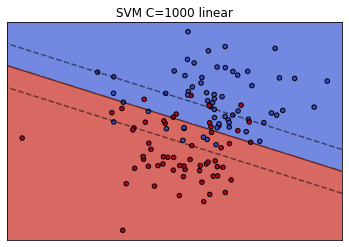

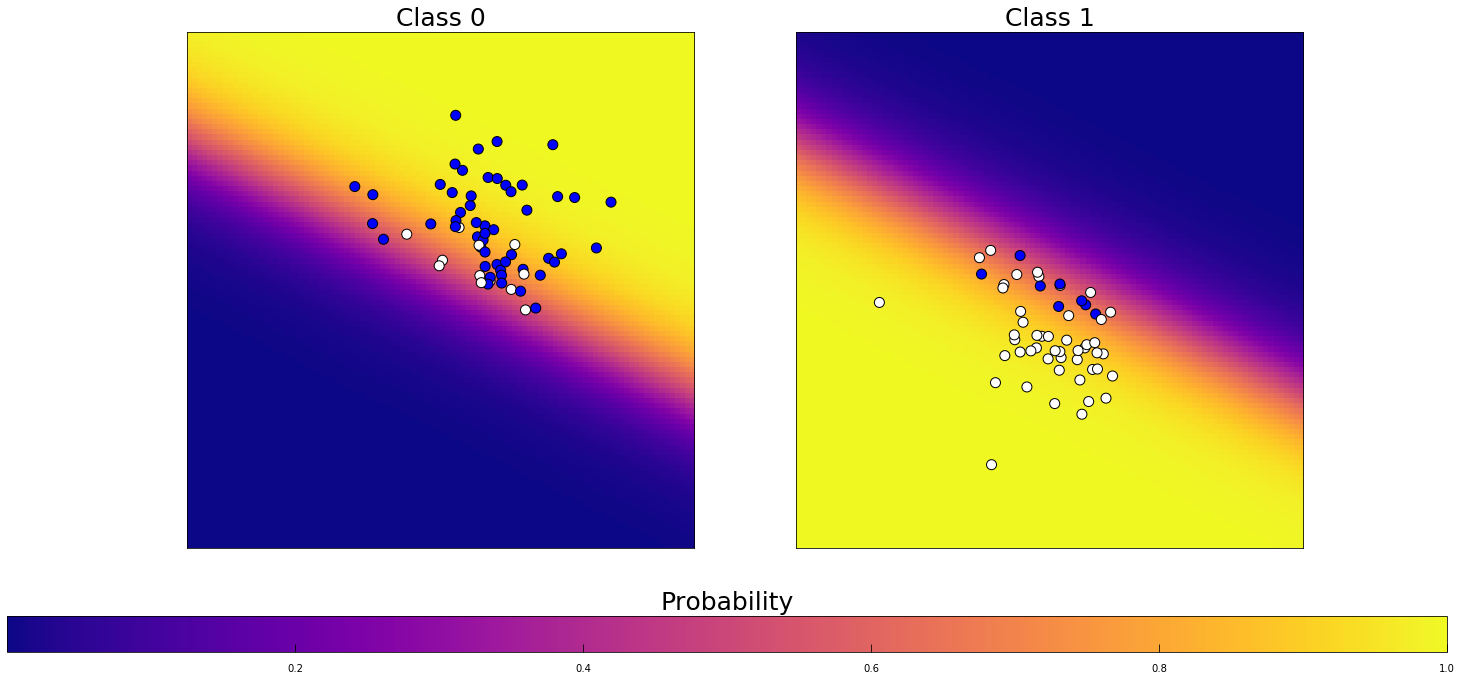

/Users/markusmueller/Documents/Teaching/SIB/ML/git/intro-machine-learning-training/python_notebooks/utils.py:563: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


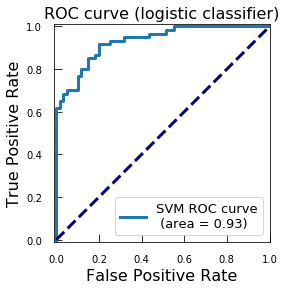

In [55]:
#let's put very little regularization
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
countour_SVM(X_toy_2,y_toy_2,1000,'linear',2,1,'ovr')

### Toy data non linear kernel <a class="anchor" id="SVM-nonlinear"></a>

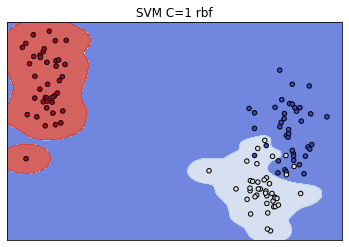

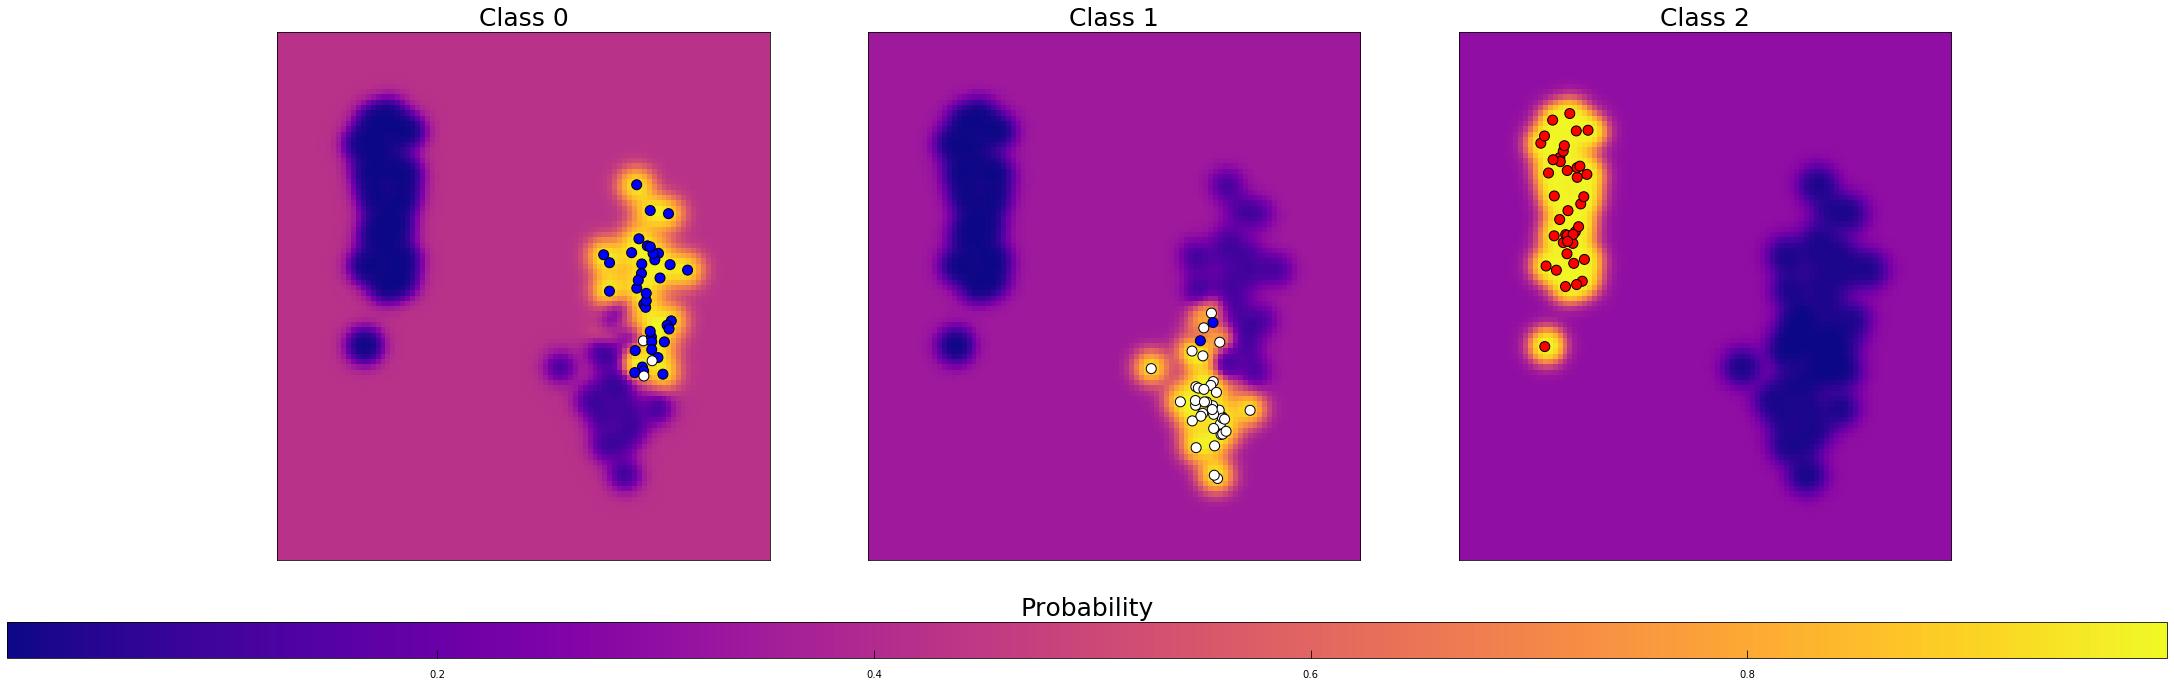

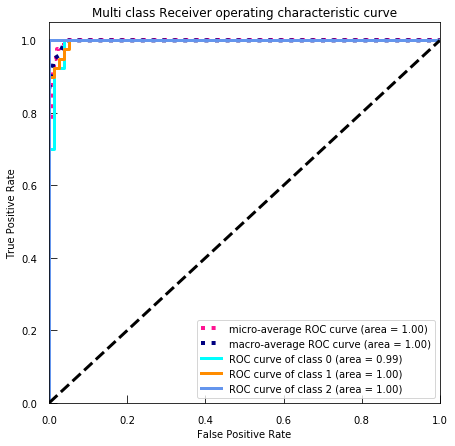

In [56]:
#let's change the scalar product and the notion of distance by using a rbf kernel
#Also we did'nt put much of regularization
#parameters:X,y,C,kernel,degree for polynomial kernel,gamma for radial kernel,multi class strategy
countour_SVM(X_3,y_3,1,'rbf',2,1,'ovr')

In the above example we changed the kernel from linear to Gaussian radial basis. See how the classification boundaries follow local class density levels?

#####

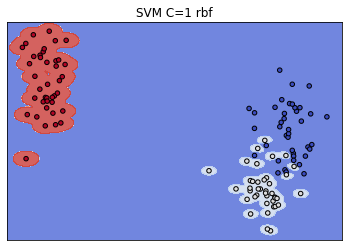

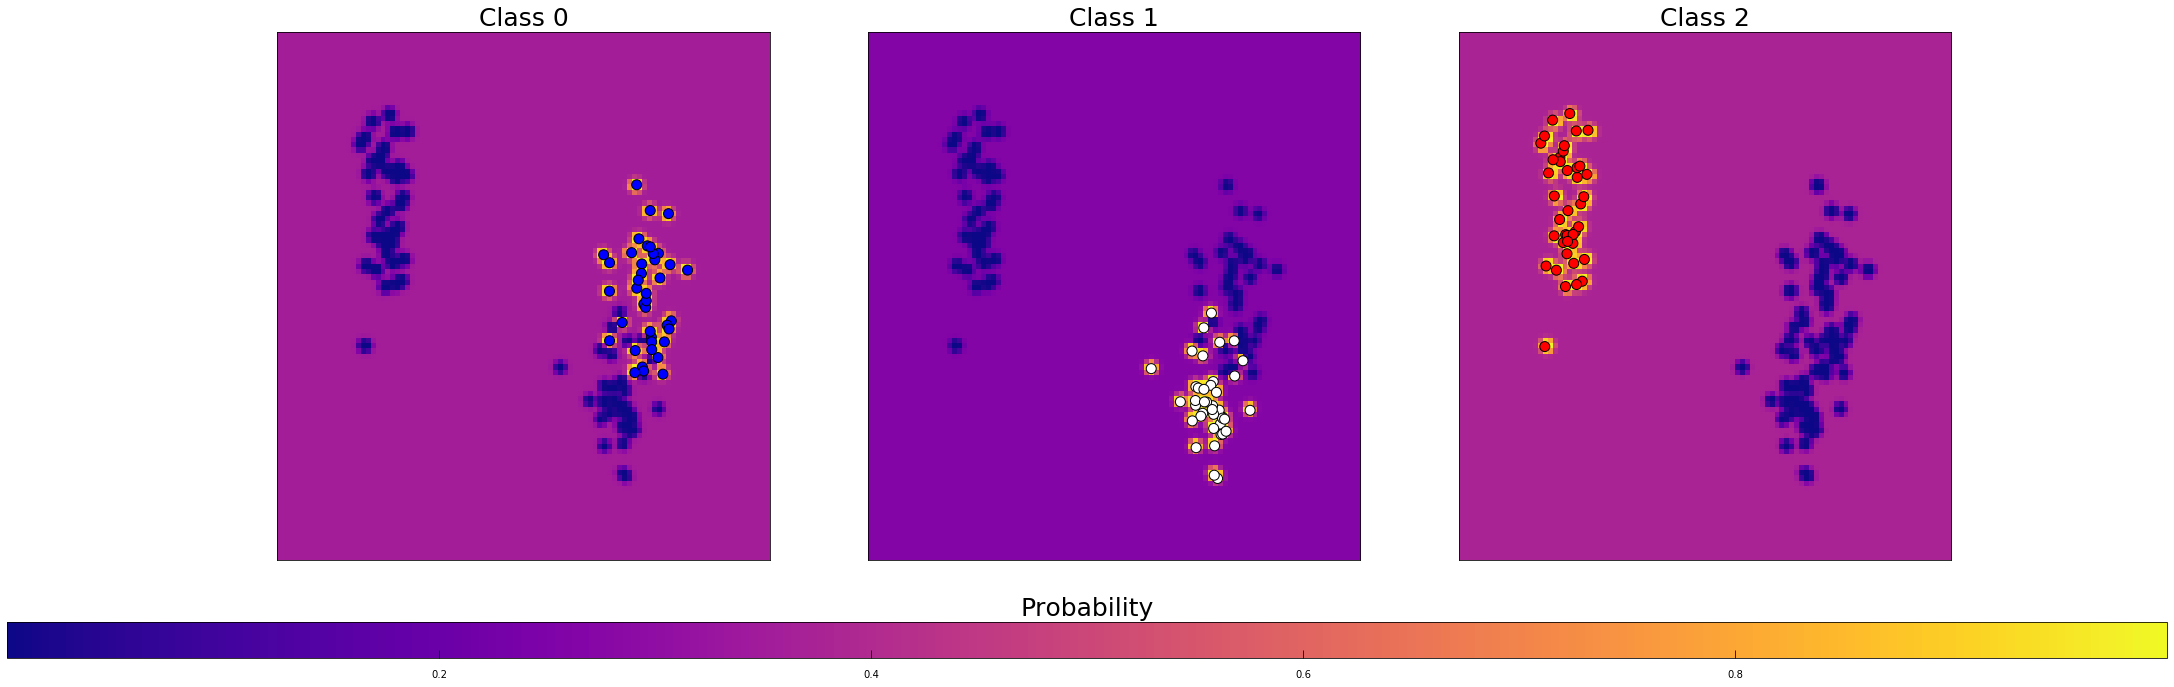

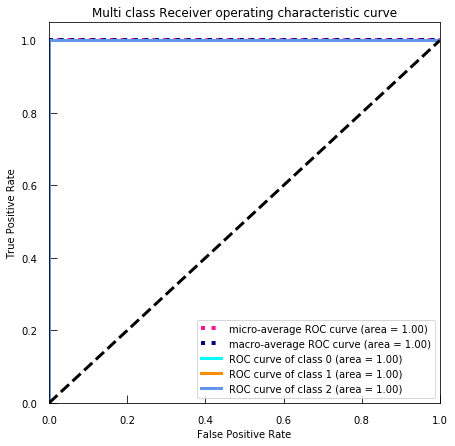

In [57]:
#even less regularization
countour_SVM(X_3,y_3,1,'rbf',2,10,'ovr')

#####

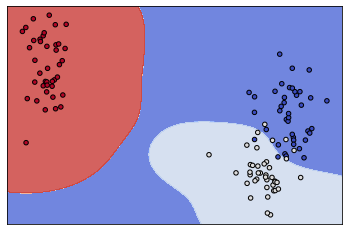

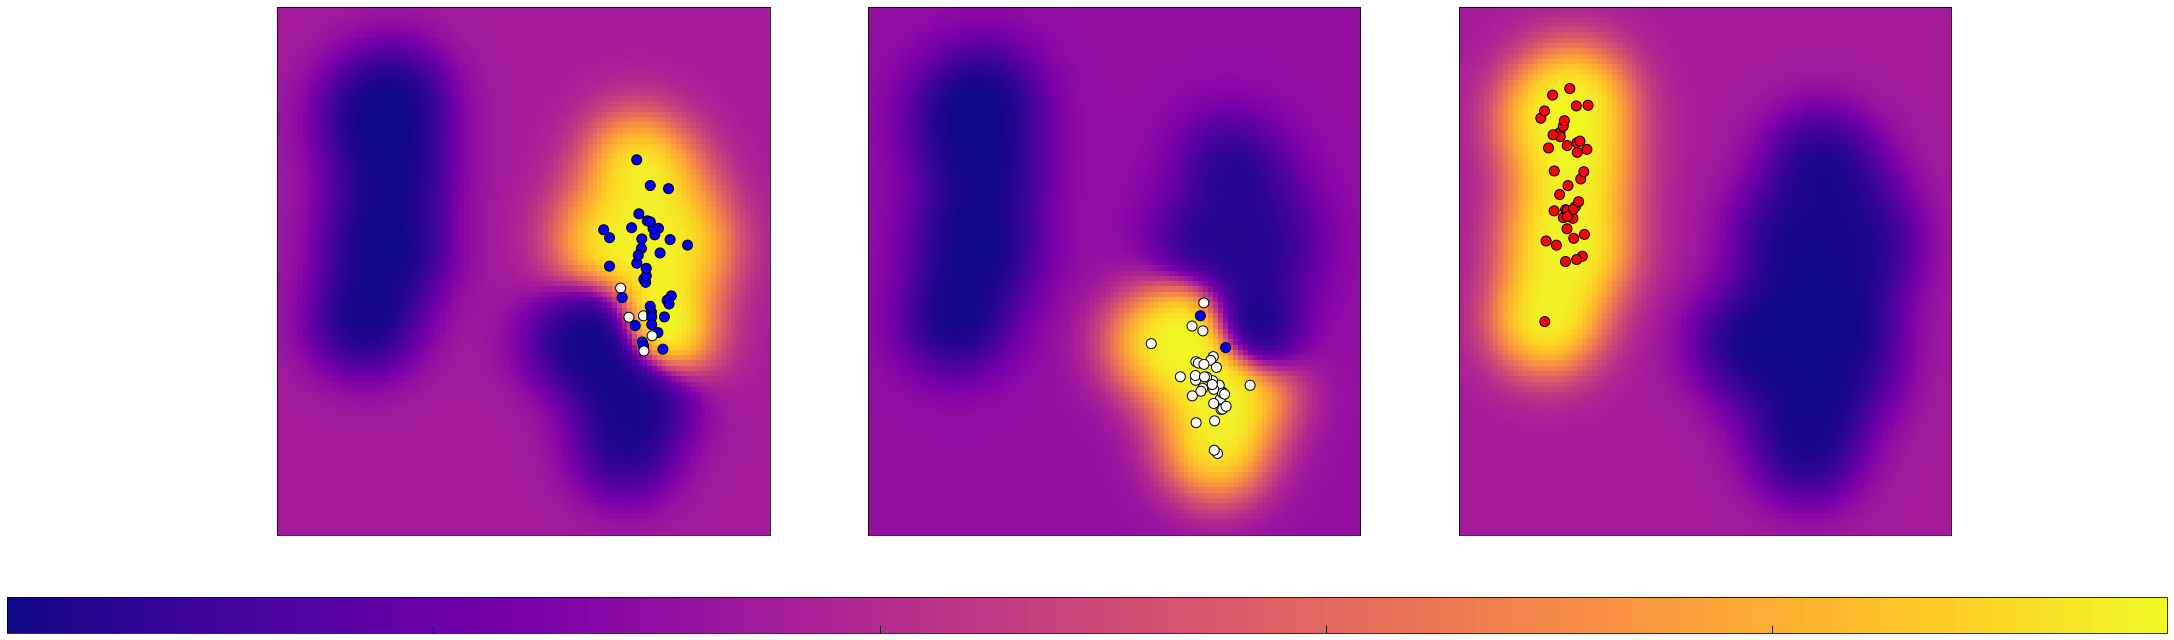

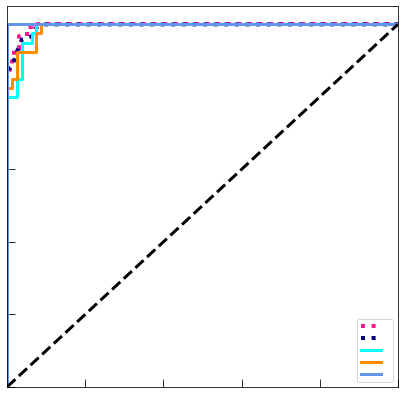

In [65]:
#more regularization
countour_SVM(X_3,y_3,1,'rbf',2,0.1,'ovr')

Inversely by expanding the variance in the gaussian we end up with larger chunks.

#### 

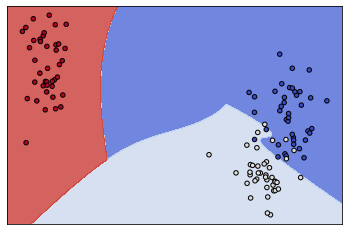

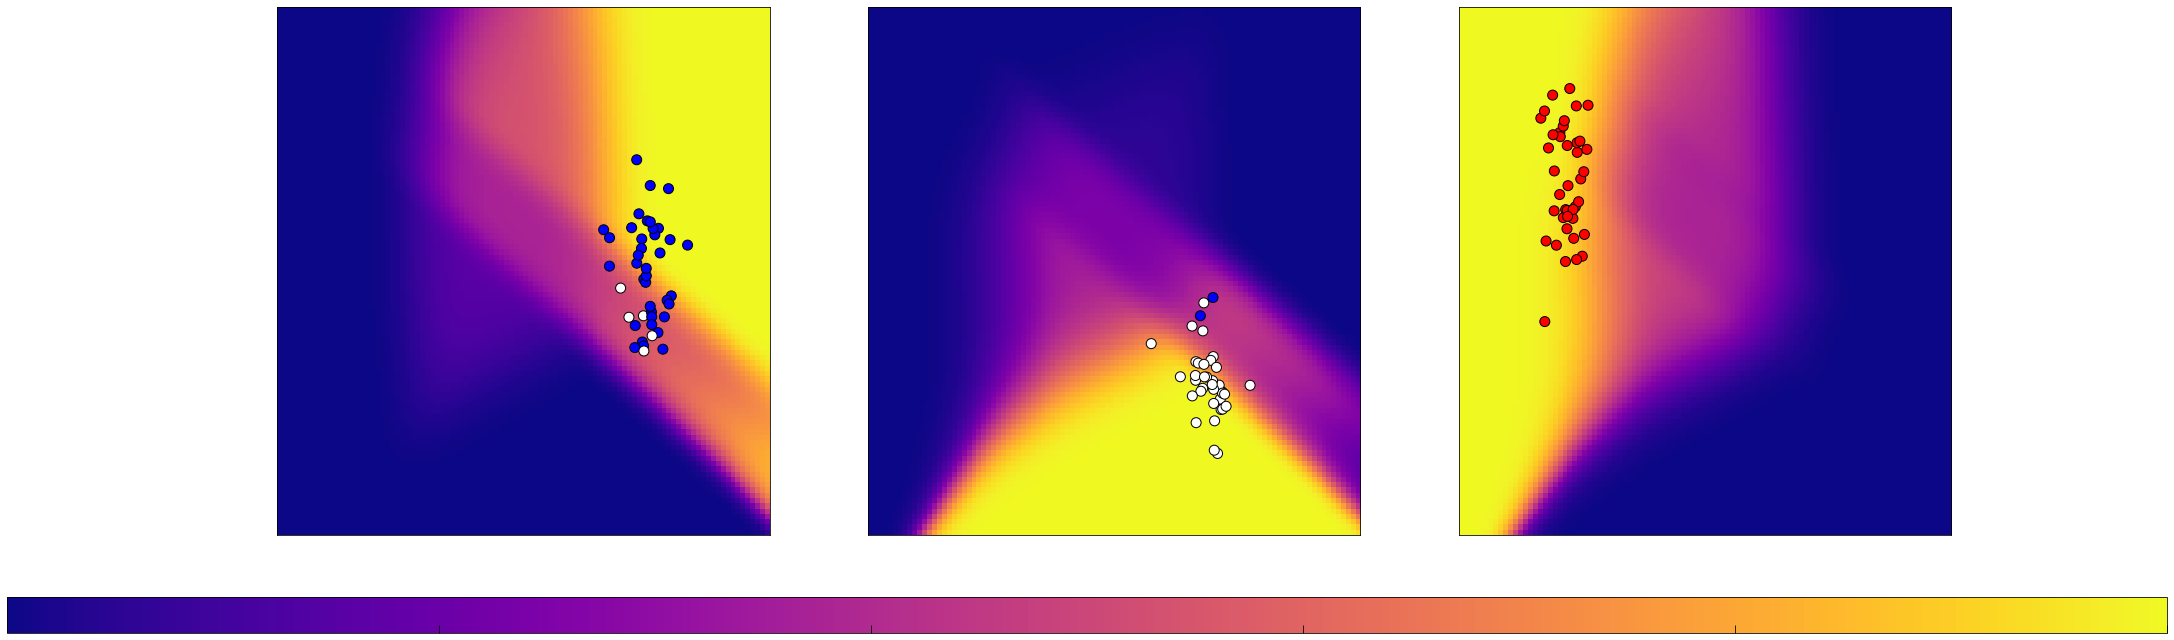

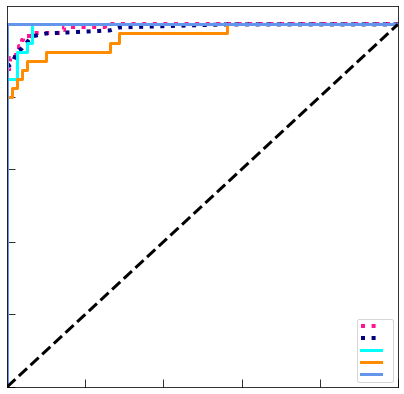

In [66]:
#little regularization but a polynomial kernel of degree 3 this time
countour_SVM(X_3,y_3,1,'poly',3,1,'ovr')

Finally, above we tried a degree 3 polynomial kernel?

### Cancer dataset <a class="anchor" id="SVM-hyperparameters"></a>

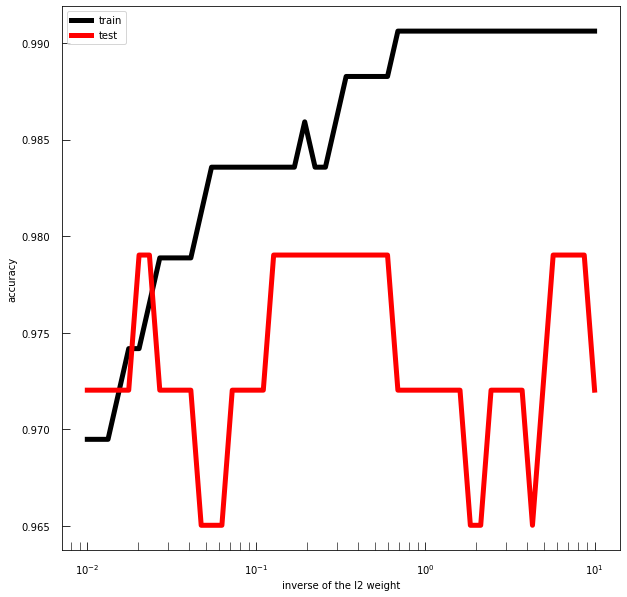

In [58]:
C_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for k in C_range: 
    SVM_r = svm.SVC(C=k, kernel='linear')
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure(figsize=(10,10))
plt.xlabel('inverse of the l2 weight')
plt.ylabel('accuracy')
plt.plot(C_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(C_range, scores_test,'r-',linewidth=5,label='test')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

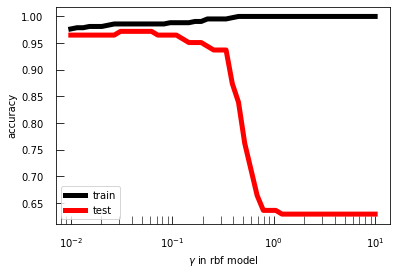

In [59]:
gamma_range=np.logspace(-2,1,50)


scores_test=[]
scores_train=[]

for k in gamma_range: 
    SVM_r = svm.SVC(C=1, kernel='rbf', degree=1, gamma= k)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('$\gamma$ in rbf model')
plt.ylabel('accuracy')
plt.plot(gamma_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(gamma_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
plt.xscale('log')
plt.legend(loc='best')
plt.show()

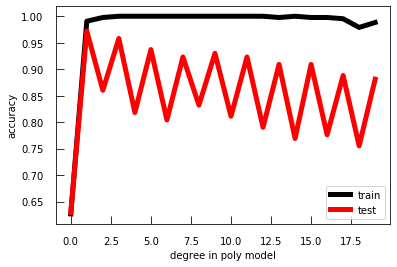

In [144]:
degree_range=np.arange(0,20,1)

scores_test=[]
scores_train=[]

for k in degree_range: 
    SVM_r = svm.SVC(C=1, kernel='poly', degree=k, gamma= 1)
    SVM_r.fit(X_cancer_train_scaled,y_cancer_train)
    scores_test.append(SVM_r.score(X_cancer_test_scaled, y_cancer_test))
    scores_train.append(SVM_r.score(X_cancer_train_scaled, y_cancer_train))

plt.figure()
plt.xlabel('degree in poly model')
plt.ylabel('accuracy')
plt.plot(degree_range, scores_train,'k-',linewidth=5,label='train')
plt.plot(degree_range, scores_test,'r-',linewidth=5,label='test')
#plt.xticks([0,20,40,60,80,100])
#plt.xscale('log')
plt.legend(loc='best')
plt.show()

Those 3 hyperparameters show the usual overfitting behaviour when they are increased : monotonous increase of the accuracy on the train function whereas there is a maximum accuracy for the test function after which accuracy decreases with increasing hyperpaprameter value.

If you want to get the weights from the SVM just use coef_ again but it will only work if you are in the context of a linear SVC.

In [60]:
svc = svm.SVC()

pipeline_svm=Pipeline([('scalar',StandardScaler()), ('model',svc)])

from sklearn.model_selection import GridSearchCV

grid_values = {'model__C': np.logspace(-2,2,20),'model__kernel':['linear','rbf'],'model__gamma':np.logspace(-2,1,10)}# define the hyperparameters you want to test
#with the range over which you want it to be tested.

grid_lr_acc = GridSearchCV(pipeline_svm, param_grid = grid_values, scoring='accuracy',n_jobs=-1)#Feed it to the GridSearchCV with the right
#score(here accuracy) over which the decision should be taken

grid_lr_acc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_acc=grid_lr_acc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. accuracy): ', grid_lr_acc.best_params_)#get the best parameters
print('Grid best score (accuracy): ', grid_lr_acc.best_score_)#get the best score calculated from the train/validation
#dataset
print('Grid best parameter (max. accuracy) model on test: ', y_decision_fn_scores_acc)# get the equivalent score on the test
#dataset : again this is the important metric

Grid best parameter (max. accuracy):  {'model__C': 5.455594781168514, 'model__gamma': 0.01, 'model__kernel': 'rbf'}
Grid best score (accuracy):  0.9788782489740082
Grid best parameter (max. accuracy) model on test:  0.965034965034965


# Appendix <a class="anchor" id="appendix"></a>

#### Logistic regression multiclass example <a class="anchor" id="LR-MC"></a>

Of course all of that can be applied to a multi-classes classification. How is it tipically done?

There are many different ways of tackling the problem, that end up being a combination of these 5 elements :

- **Either you treat the problem as one class vs one class**.

- **Or you treat the problem as a one class vs the rest : you subdivide the problem into three different problems either your are class 1 and you consider the other classes as being one big class "non 1", and you do the same for the other class**.

- **You change your loss function to a multinomial one : softmax intead of a sigmoid.** 

In any case you need to decide **how you are going to agglomerate those different statistics (different ROC curves for example)**:

-You can either do a **micro average** where you pull all your statistics together (number of FP and so on for every sub problem) and then caluclate your statistic like the TPR


-Or you can go for a **macro average** : where you calculate the satistics for each sub problem and then do the average.



Think about the differences induced by those metrics. Why should you use one more than the other? Or maybe you should always use all of them?

Spoiler is has to do with overall separability and balance between the different class.


What strategy your logistic regression uses so you can plot the right curves, is a tricky question. For a first pass on your data always set the multiclasses method to be ovr (one vs rest) : understanding the hyperplanes relation to decision probability and the ROC curve is more intuitive that way, and I believe less sensitive to imbalance dataset.

All the ROC curve below are OnevsRest unless specified.

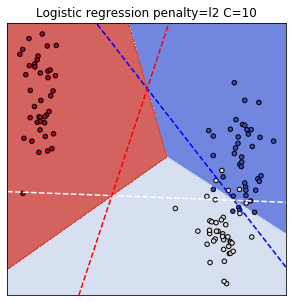

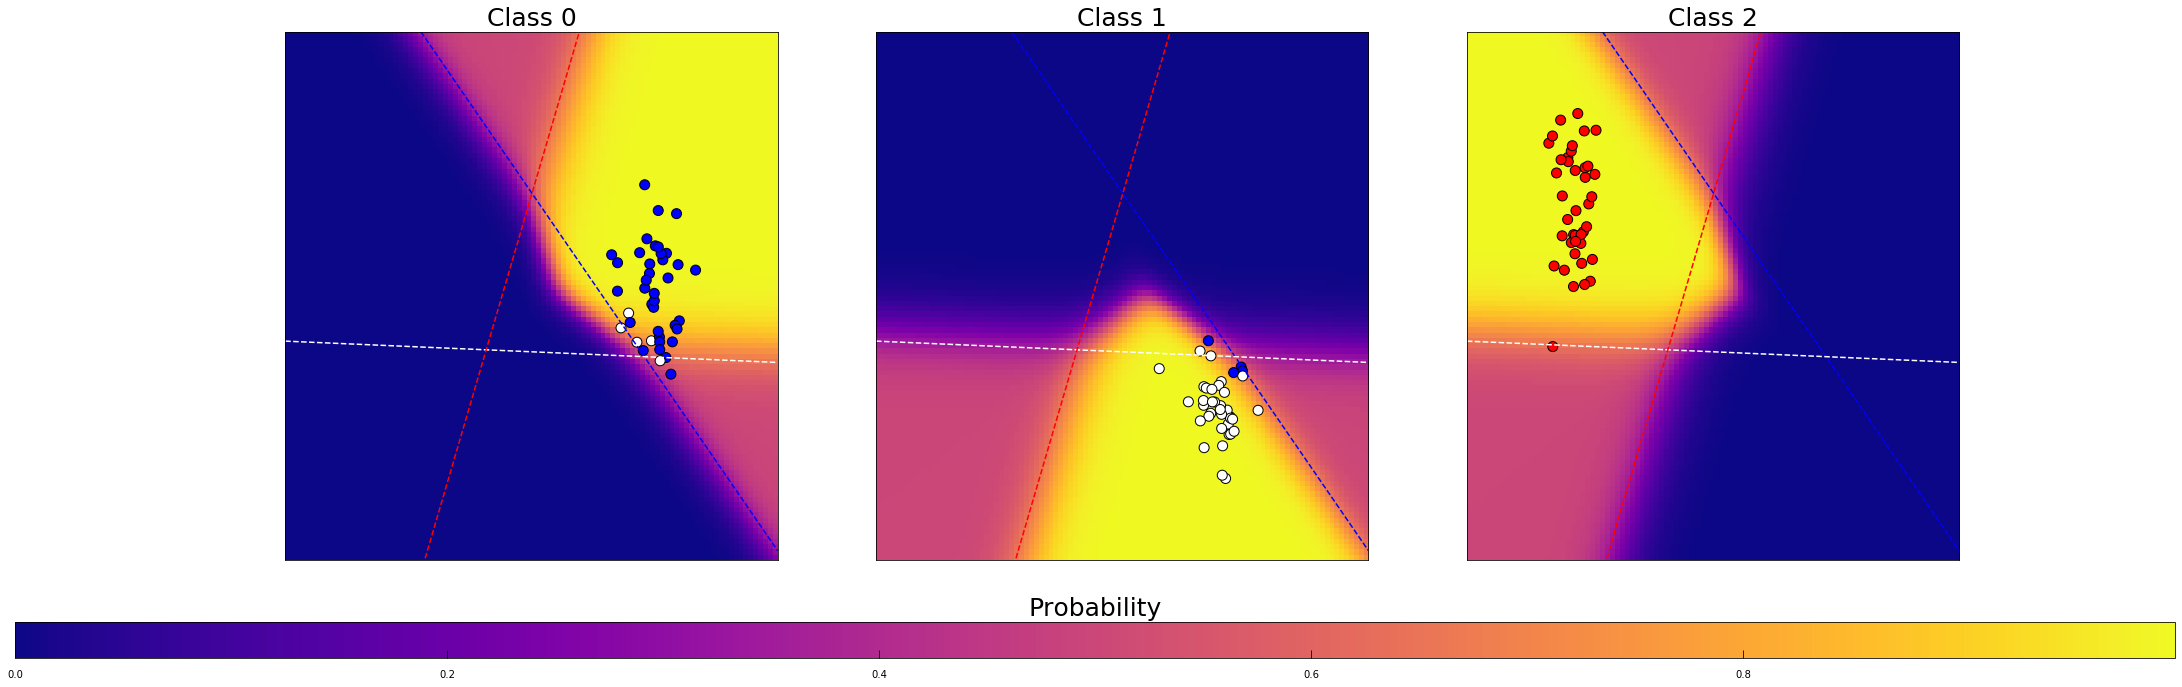

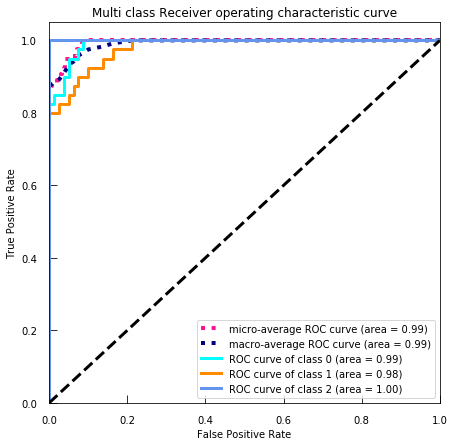

In [23]:
#one vs rest implementation
countour_lr('l2',X_3,y_3,10,'ovr')

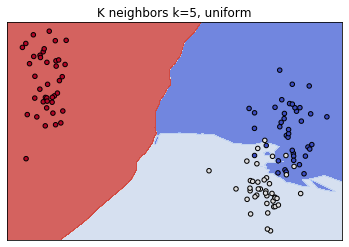

In [121]:
#Multinomial implementation : the boundaries are less interpretable
countour_lr('l2',X_3,y_3,10,'multinomial')

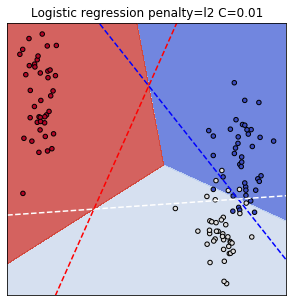

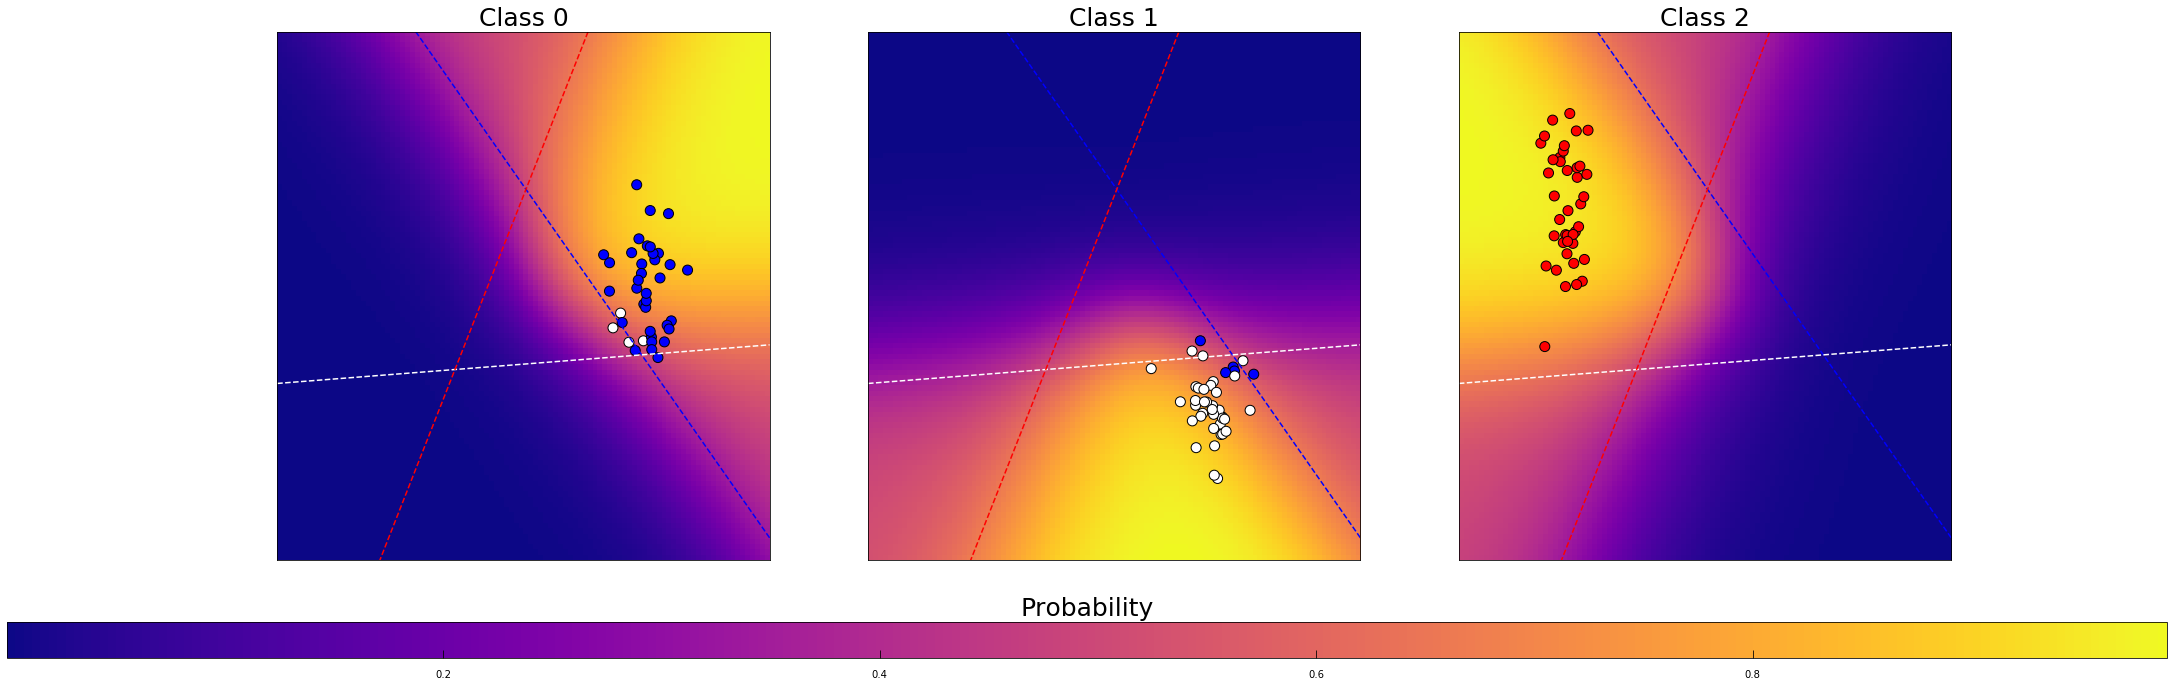

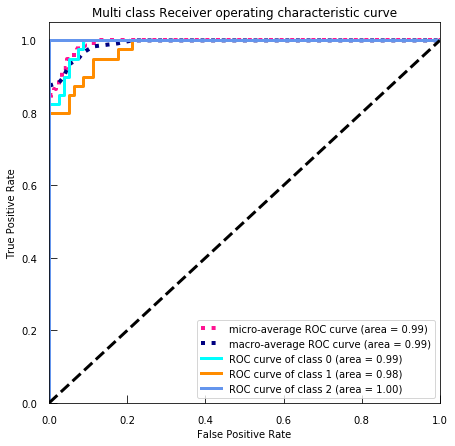

In [41]:
countour_lr('l2',X_3,y_3,10**-2,'ovr')

# Exercise <a class="anchor" id="exo"></a>

Using iris dataset compare and find the 'best' classifier. What do you learn from those classifiers? Don't forget that you have also seen stuff about preprocessing.

Don't go to crazy as it can be time consuming: big gridsize spacing.

Hint : before, your grid_param was a dictionnary, and it was specific to a particular model since parameters are model dependant. Try to make a list of grid_params where each instance of the list is a dictionnary of parameters specific to the model, you want to try.
Example:

grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 },
                {"classifier": [LogisticRegression()],
                 "classifier__penalty": ['l2','l1'],
                 }]

Questions : How would you work with your PCA data and incorporate it to your model?

Hint: Don't forget that PCA needs a centering and a scaling step...

Hint: adding PCA can be quite time consuming too. Try a small number of pca components first with other hyperparameters centered around what you found before!

In [149]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

#Next cell is correction!So work above!

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#




#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#


#

# One possible correction

In [155]:
pipe = Pipeline([('scalar',StandardScaler()),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                {"classifier": [KNeighborsClassifier()],
                 "classifier__n_neighbors": np.arange(1,30,1),
                 "classifier__weights": ['uniform','distance']
                 },
                {"classifier": [LogisticRegression(solver='saga',max_iter=300)],
                 "classifier__penalty": ['l2','l1'],
                 "classifier__C": np.logspace(-2, 2, 10)
                 },
                {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf', 'poly'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__degree":np.arange(0,20,1),
                 "classifier__gamma": np.logspace(-2,1,10)}]

gridsearch_i = GridSearchCV(pipe, grid_param, cv=5, verbose=0) # Fit grid search
best_model_i = gridsearch_i.fit(X_iris_train,y_iris_train)

print(best_model_i.best_estimator_)
print("Model accuracy:",best_model_i.score(X_iris_test,y_iris_test))

/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklea

/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(steps=[('scalar', StandardScaler()),
                ('classifier',
                 LogisticRegression(C=35.93813663804626, max_iter=300,
                                    solver='saga'))])
Model accuracy: 1.0


/Users/markusmueller/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [156]:
grid_param = [  {"classifier": [svm.SVC()],
                 "classifier__kernel": ['linear', 'rbf'],
                 "classifier__C":np.logspace(-2, 2, 10),
                 "classifier__gamma": np.logspace(-2,1,10)}]

In [158]:
from sklearn.decomposition import PCA

pipe_pca = Pipeline([('scalar1',StandardScaler()),('pca',PCA(n_components=2)),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters

# create a gridsearch of the pipeline, the fit the best model
gridsearch_c_pca = GridSearchCV(pipe_pca, grid_param, cv=5, verbose=0) # Fit grid search

best_model_c_pca = gridsearch_c_pca.fit(X_iris_train,y_iris_train)

In [159]:
print(best_model_c_pca.best_estimator_)
print("Model accuracy:",best_model_c_pca.score(X_iris_test,y_iris_test))

Pipeline(steps=[('scalar1', StandardScaler()), ('pca', PCA(n_components=2)),
                ('classifier',
                 SVC(C=4.6415888336127775, gamma=0.01, kernel='linear'))])
Model accuracy: 0.9473684210526315


In [161]:
pipe_pca = Pipeline([('scalar1',StandardScaler()),('pca',PCA(n_components=3)),("classifier", KNeighborsClassifier())])
# Create dictionary with candidate learning algorithms and their hyperparameters

# create a gridsearch of the pipeline, the fit the best model
gridsearch_c_pca = GridSearchCV(pipe_pca, grid_param, cv=5, verbose=0) # Fit grid search

best_model_c_pca = gridsearch_c_pca.fit(X_iris_train,y_iris_train)


print(best_model_c_pca.best_estimator_)
print("Model accuracy:",best_model_c_pca.score(X_iris_test,y_iris_test))

Pipeline(steps=[('scalar1', StandardScaler()), ('pca', PCA(n_components=3)),
                ('classifier',
                 SVC(C=12.915496650148826, gamma=0.021544346900318832))])
Model accuracy: 1.0
